In [1]:
import os
print(os.getcwd())

/Users/dhruvsharma/Desktop/Stats/Project


In [73]:
import pandas as pd

# Path to K-index file
file_path = "/Users/dhruvsharma/Desktop/Stats/Project/df_k_cleaned.csv"

# Load into a DataFrame
df_k_cleaned = pd.read_csv(file_path)

# Preview
print("Shape:", df_k_cleaned.shape)
print("Columns:", df_k_cleaned.columns.tolist())
print("\nPreview of data:")
print(df_k_cleaned.head())


Shape: (366, 26)
Columns: ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'date', 'was_imputed_k1', 'was_imputed_k2', 'was_imputed_k3', 'was_imputed_k4', 'was_imputed_k5', 'was_imputed_k6', 'was_imputed_k7', 'was_imputed_k8', 'K_max', 'is_storm', 'storm_group', 'month', 'K_sum', 'season', 'is_storm_day', 'k_value', 'K_weighted_sum']

Preview of data:
    k1   k2   k3   k4   k5   k6   k7   k8        date  was_imputed_k1  ...  \
0  3.0  4.0  3.0  2.0  2.0  0.0  2.0  2.0  2016-01-01           False  ...   
1  3.0  2.0  3.0  2.0  2.0  2.0  2.0  1.0  2016-01-02           False  ...   
2  1.0  3.0  2.0  2.0  1.0  2.0  2.0  2.0  2016-01-03           False  ...   
3  2.0  1.0  2.0  1.0  1.0  2.0  2.0  2.0  2016-01-04           False  ...   
4  2.0  2.0  2.0  2.0  1.0  2.0  2.0  2.0  2016-01-05           False  ...   

   was_imputed_k8  K_max  is_storm  storm_group    month  K_sum  season  \
0           False    4.0     False            1  January   18.0  Summer   
1           False    3.0   

Linear Regression


Linear Regression Evaluation (Lags 1–8):
RMSE  : 0.7665
MAE   : 0.6073
R²    : 0.4594


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


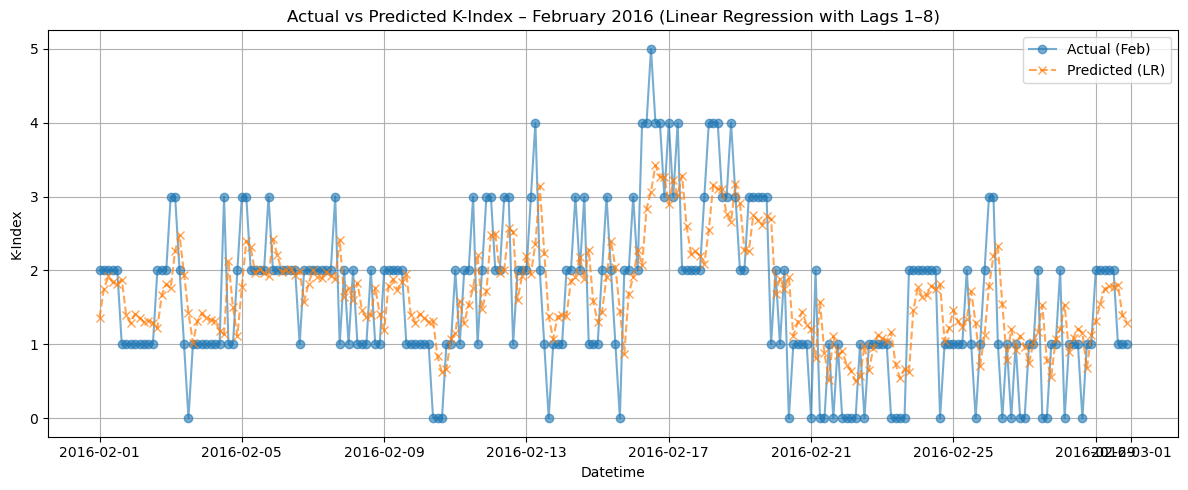


Stored in: results_lr
RMSE_LR = 0.7665, MAE_LR = 0.6073, R2_LR = 0.4594


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Convert df_k_cleaned to long format
k_columns = [f'k{i}' for i in range(1, 9)]
k_long = df_k_cleaned.melt(id_vars='date', value_vars=k_columns,
                           var_name='interval', value_name='k_value_lag')

interval_map = {
    'k1': '00:00', 'k2': '03:00', 'k3': '06:00', 'k4': '09:00',
    'k5': '12:00', 'k6': '15:00', 'k7': '18:00', 'k8': '21:00'
}
k_long['time'] = k_long['interval'].map(interval_map)
k_long['datetime'] = pd.to_datetime(k_long['date'] + ' ' + k_long['time'])
k_long = k_long.sort_values('datetime').reset_index(drop=True)

# STEP 2: Filter Jan + Feb 2016 
df_2016 = k_long[(k_long['datetime'] >= '2016-01-01') & (k_long['datetime'] < '2016-03-01')].copy()

# STEP 3: Create Lag Features (1–8)
for lag in range(1, 9):
    df_2016[f'k_lag{lag}'] = df_2016['k_value_lag'].shift(lag)

df_2016 = df_2016.dropna().reset_index(drop=True)

# STEP 4: Split Jan (train) vs Feb (test)
jan_df = df_2016[df_2016['datetime'] < '2016-02-01']
feb_df = df_2016[df_2016['datetime'] >= '2016-02-01']

X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]]
y_train = jan_df['k_value_lag']
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]]
y_test = feb_df['k_value_lag']

# STEP 5: Train Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# STEP 6: Evaluation metrics
RMSE_LR = mean_squared_error(y_test, y_pred, squared=False)
MAE_LR = mean_absolute_error(y_test, y_pred)
R2_LR = r2_score(y_test, y_pred)

print("Linear Regression Evaluation (Lags 1–8):")
print(f"RMSE  : {RMSE_LR:.4f}")
print(f"MAE   : {MAE_LR:.4f}")
print(f"R²    : {R2_LR:.4f}")

# STEP 7: Store results for plotting
results_lr = feb_df[['datetime']].copy()
results_lr['actual_k'] = y_test.values
results_lr['predicted_k_lr'] = y_pred

# STEP 8: Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(results_lr['datetime'], results_lr['actual_k'], label='Actual (Feb)', marker='o', linestyle='-', alpha=0.6)
plt.plot(results_lr['datetime'], results_lr['predicted_k_lr'], label='Predicted (LR)', marker='x', linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted K-Index – February 2016 (Linear Regression with Lags 1–8)")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#STEP 9: Preview
print("\nStored in: results_lr")
print(f"RMSE_LR = {RMSE_LR:.4f}, MAE_LR = {MAE_LR:.4f}, R2_LR = {R2_LR:.4f}")


Ramdom Forest

 Random Forest Evaluation (Lags 1–8):
RMSE  : 0.8799
MAE   : 0.6841
R²    : 0.2876


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


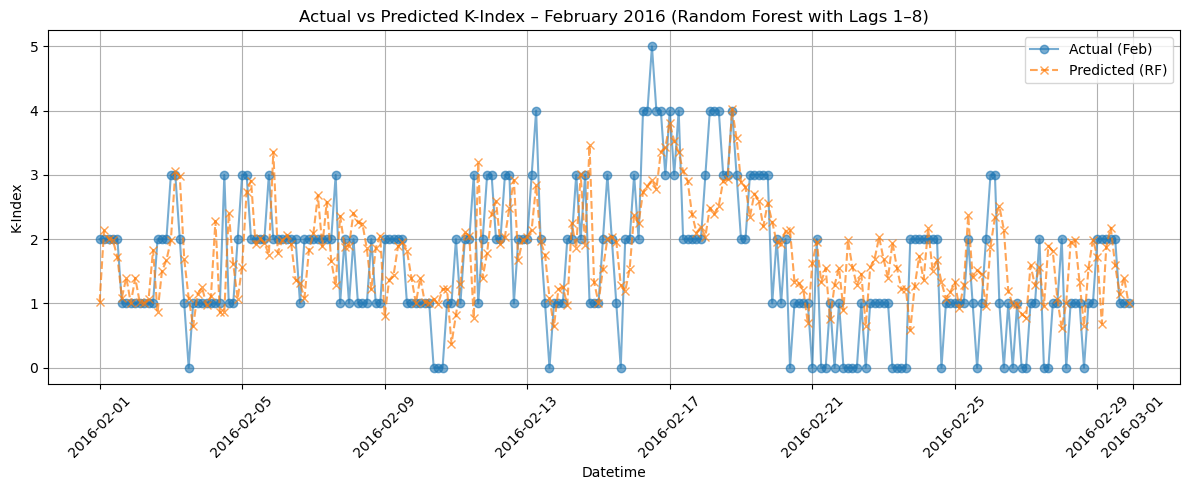


 Stored in: results_rf
 RMSE_RF = 0.8799, MAE_RF = 0.6841, R2_RF = 0.2876


In [75]:
from sklearn.ensemble import RandomForestRegressor

# STEP 1: Data Preparation
k_columns = [f'k{i}' for i in range(1, 9)]
k_long = df_k_cleaned.melt(id_vars='date', value_vars=k_columns,
                           var_name='interval', value_name='k_value_lag')

interval_map = {
    'k1': '00:00', 'k2': '03:00', 'k3': '06:00', 'k4': '09:00',
    'k5': '12:00', 'k6': '15:00', 'k7': '18:00', 'k8': '21:00'
}
k_long['time'] = k_long['interval'].map(interval_map)
k_long['datetime'] = pd.to_datetime(k_long['date'] + ' ' + k_long['time'])
k_long = k_long.sort_values('datetime').reset_index(drop=True)

# STEP 2: Filter Jan + Feb 2016
df_2016 = k_long[(k_long['datetime'] >= '2016-01-01') & (k_long['datetime'] < '2016-03-01')].copy()

# STEP 3: Create Lag Features (1–8)
for lag in range(1, 9):
    df_2016[f'k_lag{lag}'] = df_2016['k_value_lag'].shift(lag)

df_2016 = df_2016.dropna().reset_index(drop=True)

# STEP 4: Train-Test Split (Jan vs Feb)
jan_df = df_2016[df_2016['datetime'] < '2016-02-01']
feb_df = df_2016[df_2016['datetime'] >= '2016-02-01']

X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]]
y_train = jan_df['k_value_lag']
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]]
y_test = feb_df['k_value_lag']

# STEP 5: Train Random Forest Model 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# STEP 6: Evaluate Performance
RMSE_RF = mean_squared_error(y_test, y_pred_rf, squared=False)
MAE_RF = mean_absolute_error(y_test, y_pred_rf)
R2_RF = r2_score(y_test, y_pred_rf)

print(" Random Forest Evaluation (Lags 1–8):")
print(f"RMSE  : {RMSE_RF:.4f}")
print(f"MAE   : {MAE_RF:.4f}")
print(f"R²    : {R2_RF:.4f}")

# STEP 7: Store results for Random Forest
results_rf = feb_df[['datetime']].copy()
results_rf['actual_k'] = y_test.values
results_rf['predicted_k_rf'] = y_pred_rf

# STEP 8: Plot
plt.figure(figsize=(12, 5))
plt.plot(results_rf['datetime'], results_rf['actual_k'], label='Actual (Feb)', marker='o', linestyle='-', alpha=0.6)
plt.plot(results_rf['datetime'], results_rf['predicted_k_rf'], label='Predicted (RF)', marker='x', linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted K-Index – February 2016 (Random Forest with Lags 1–8)")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# STEP 9: Store Evaluation Metrics
print("\n Stored in: results_rf")
print(f" RMSE_RF = {RMSE_RF:.4f}, MAE_RF = {MAE_RF:.4f}, R2_RF = {R2_RF:.4f}")


XGBoost

 XGBoost Evaluation (Lags 1–8):
RMSE  : 0.9353
MAE   : 0.7511
R²    : 0.1950


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


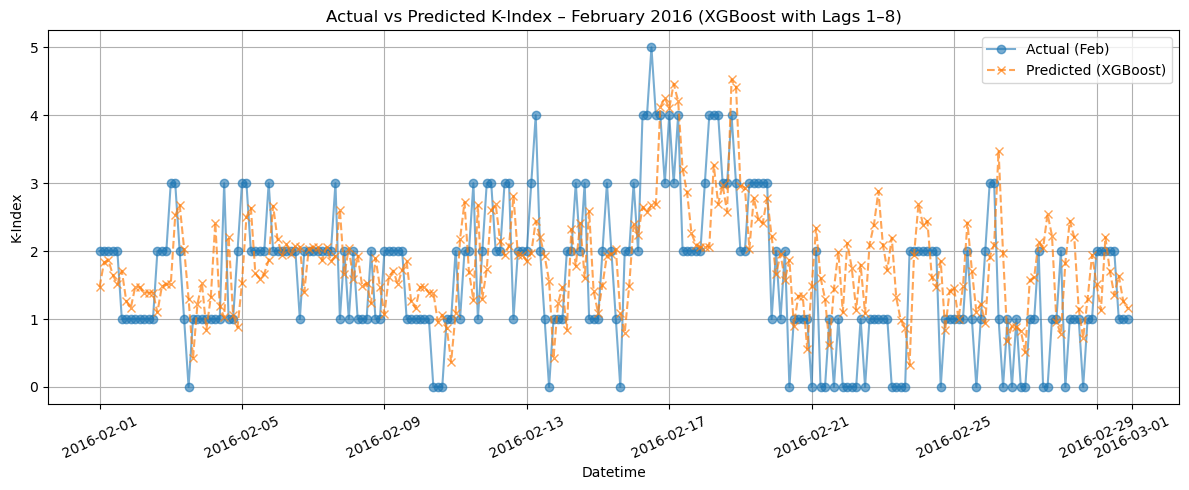


 Stored in: results_xgb
 RMSE_XGB = 0.9353, MAE_XGB = 0.7511, R2_XGB = 0.1950


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Data Preparation
k_columns = [f'k{i}' for i in range(1, 9)]
k_long = df_k_cleaned.melt(id_vars='date', value_vars=k_columns,
                           var_name='interval', value_name='k_value_lag')

interval_map = {
    'k1': '00:00', 'k2': '03:00', 'k3': '06:00', 'k4': '09:00',
    'k5': '12:00', 'k6': '15:00', 'k7': '18:00', 'k8': '21:00'
}
k_long['time'] = k_long['interval'].map(interval_map)
k_long['datetime'] = pd.to_datetime(k_long['date'] + ' ' + k_long['time'])
k_long = k_long.sort_values('datetime').reset_index(drop=True)

# STEP 2: Filter Jan + Feb 2016
df_2016 = k_long[(k_long['datetime'] >= '2016-01-01') & (k_long['datetime'] < '2016-03-01')].copy()

# STEP 3: Create Lag Features (1–8)
for lag in range(1, 9):
    df_2016[f'k_lag{lag}'] = df_2016['k_value_lag'].shift(lag)

df_2016 = df_2016.dropna().reset_index(drop=True)

# STEP 4: Train-Test Split (Jan vs Feb)
jan_df = df_2016[df_2016['datetime'] < '2016-02-01']
feb_df = df_2016[df_2016['datetime'] >= '2016-02-01']

X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]]
y_train = jan_df['k_value_lag']
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]]
y_test = feb_df['k_value_lag']

# STEP 5: Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# STEP 6: Evaluate Performance
RMSE_XGB = mean_squared_error(y_test, y_pred_xgb, squared=False)
MAE_XGB = mean_absolute_error(y_test, y_pred_xgb)
R2_XGB = r2_score(y_test, y_pred_xgb)

print(" XGBoost Evaluation (Lags 1–8):")
print(f"RMSE  : {RMSE_XGB:.4f}")
print(f"MAE   : {MAE_XGB:.4f}")
print(f"R²    : {R2_XGB:.4f}")

# STEP 7: Store results for XGBoost
results_xgb = feb_df[['datetime']].copy()
results_xgb['actual_k'] = y_test.values
results_xgb['predicted_k_xgb'] = y_pred_xgb

# STEP 8: Plot
plt.figure(figsize=(12, 5))
plt.plot(results_xgb['datetime'], results_xgb['actual_k'], label='Actual (Feb)', marker='o', linestyle='-', alpha=0.6)
plt.plot(results_xgb['datetime'], results_xgb['predicted_k_xgb'], label='Predicted (XGBoost)', marker='x', linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted K-Index – February 2016 (XGBoost with Lags 1–8)")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# STEP 9: Store Evaluation Metrics
print("\n Stored in: results_xgb")
print(f" RMSE_XGB = {RMSE_XGB:.4f}, MAE_XGB = {MAE_XGB:.4f}, R2_XGB = {R2_XGB:.4f}")


Gradient Boosting

 Gradient Boosting Evaluation (Lags 1–8):
RMSE  : 0.9282
MAE   : 0.7486
R²    : 0.2072


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


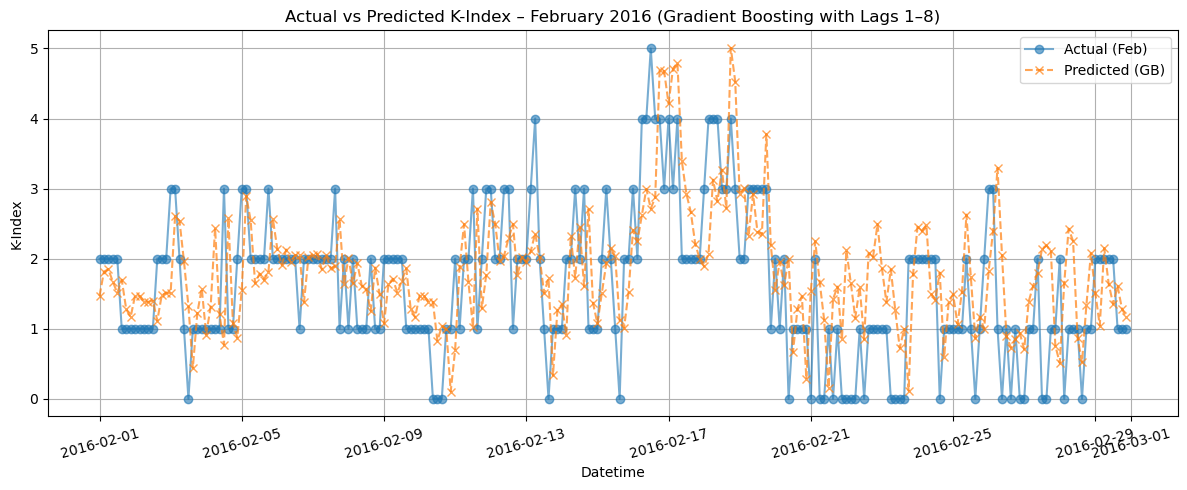


 Stored in: results_gb
 RMSE_GB = 0.9282, MAE_GB = 0.7486, R2_GB = 0.2072


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#STEP 1: Data Preparation (assumes df_k_cleaned already loaded)
k_columns = [f'k{i}' for i in range(1, 9)]
k_long = df_k_cleaned.melt(id_vars='date', value_vars=k_columns,
                           var_name='interval', value_name='k_value_lag')

interval_map = {
    'k1': '00:00', 'k2': '03:00', 'k3': '06:00', 'k4': '09:00',
    'k5': '12:00', 'k6': '15:00', 'k7': '18:00', 'k8': '21:00'
}
k_long['time'] = k_long['interval'].map(interval_map)
k_long['datetime'] = pd.to_datetime(k_long['date'] + ' ' + k_long['time'])
k_long = k_long.sort_values('datetime').reset_index(drop=True)

# STEP 2: Filter Jan + Feb 2016
df_2016 = k_long[(k_long['datetime'] >= '2016-01-01') & (k_long['datetime'] < '2016-03-01')].copy()

# STEP 3: Create Lag Features (1–8)
for lag in range(1, 9):
    df_2016[f'k_lag{lag}'] = df_2016['k_value_lag'].shift(lag)

df_2016 = df_2016.dropna().reset_index(drop=True)

# STEP 4: Train-Test Split (Jan vs Feb)
jan_df = df_2016[df_2016['datetime'] < '2016-02-01']
feb_df = df_2016[df_2016['datetime'] >= '2016-02-01']

X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]]
y_train = jan_df['k_value_lag']
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]]
y_test = feb_df['k_value_lag']

# STEP 5: Train Gradient Boosting Model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# STEP 6: Evaluate Performance
RMSE_GB = mean_squared_error(y_test, y_pred_gb, squared=False)
MAE_GB = mean_absolute_error(y_test, y_pred_gb)
R2_GB = r2_score(y_test, y_pred_gb)

print(" Gradient Boosting Evaluation (Lags 1–8):")
print(f"RMSE  : {RMSE_GB:.4f}")
print(f"MAE   : {MAE_GB:.4f}")
print(f"R²    : {R2_GB:.4f}")

# STEP 7: Store results for Gradient Boosting
results_gb = feb_df[['datetime']].copy()
results_gb['actual_k'] = y_test.values
results_gb['predicted_k_gb'] = y_pred_gb

# STEP 8: Plot
plt.figure(figsize=(12, 5))
plt.plot(results_gb['datetime'], results_gb['actual_k'], label='Actual (Feb)', marker='o', linestyle='-', alpha=0.6)
plt.plot(results_gb['datetime'], results_gb['predicted_k_gb'], label='Predicted (GB)', marker='x', linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted K-Index – February 2016 (Gradient Boosting with Lags 1–8)")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# STEP 9: Store Evaluation Metrics
print("\n Stored in: results_gb")
print(f" RMSE_GB = {RMSE_GB:.4f}, MAE_GB = {MAE_GB:.4f}, R2_GB = {R2_GB:.4f}")


Comparision of Models.

/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_43020/341821355.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15)
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_43020/341821355.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15)
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_43020/341821355.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15)


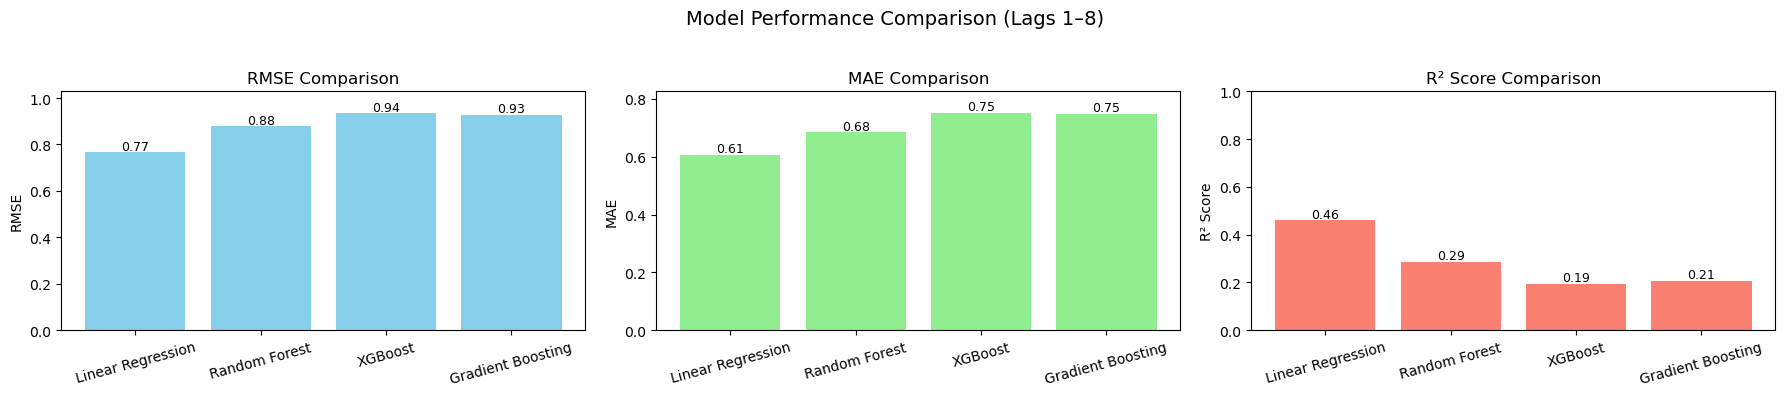

In [79]:
import matplotlib.pyplot as plt

# Define model names and metric values
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting']
rmse_values = [RMSE_LR, RMSE_RF, RMSE_XGB, RMSE_GB]
mae_values = [MAE_LR, MAE_RF, MAE_XGB, MAE_GB]
r2_values = [R2_LR, R2_RF, R2_XGB, R2_GB]

fig, axes = plt.subplots(1, 3, figsize=(18, 4), dpi=100)

# RMSE Plot
axes[0].bar(models, rmse_values, color='skyblue')
axes[0].set_title('RMSE Comparison')
axes[0].set_ylabel('RMSE')
axes[0].set_ylim(0, max(rmse_values)*1.1)
for i, val in enumerate(rmse_values):
    axes[0].text(i, val + 0.01, f'{val:.2f}', ha='center', fontsize=9)

# MAE Plot
axes[1].bar(models, mae_values, color='lightgreen')
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('MAE')
axes[1].set_ylim(0, max(mae_values)*1.1)
for i, val in enumerate(mae_values):
    axes[1].text(i, val + 0.01, f'{val:.2f}', ha='center', fontsize=9)

# R² Score Plot
axes[2].bar(models, r2_values, color='salmon')
axes[2].set_title('R² Score Comparison')
axes[2].set_ylabel('R² Score')
axes[2].set_ylim(0, 1)
for i, val in enumerate(r2_values):
    axes[2].text(i, val + 0.01, f'{val:.2f}', ha='center', fontsize=9)

for ax in axes:
    ax.set_xticklabels(models, rotation=15)

plt.suptitle("Model Performance Comparison (Lags 1–8)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Hyper Parameter Tunning for Models using K-index

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


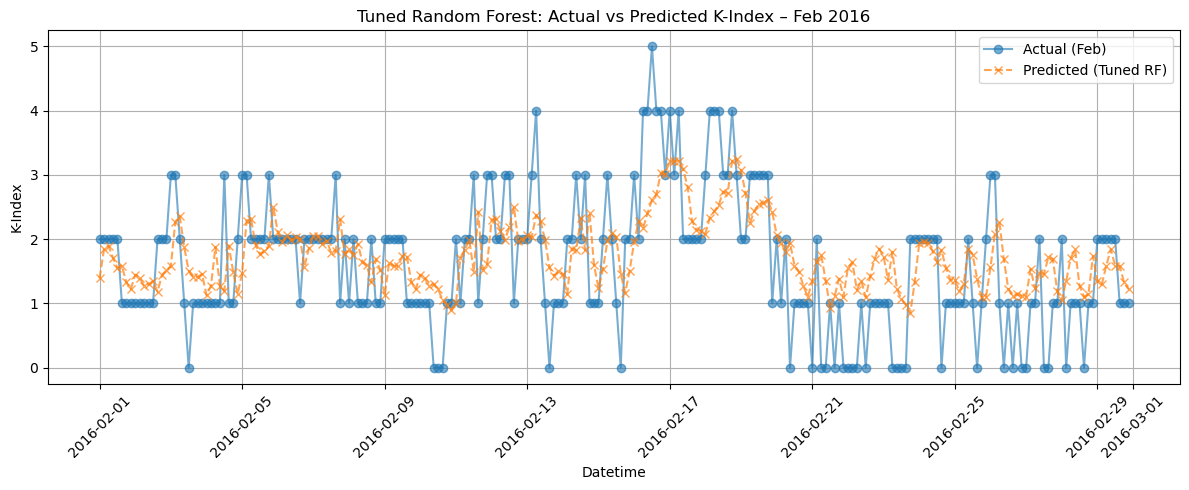

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Prepare Data from df_k_cleaned
k_columns = [f'k{i}' for i in range(1, 9)]
k_long = df_k_cleaned.melt(id_vars='date', value_vars=k_columns,
                           var_name='interval', value_name='k_value_lag')

interval_map = {
    'k1': '00:00', 'k2': '03:00', 'k3': '06:00', 'k4': '09:00',
    'k5': '12:00', 'k6': '15:00', 'k7': '18:00', 'k8': '21:00'
}
k_long['time'] = k_long['interval'].map(interval_map)
k_long['datetime'] = pd.to_datetime(k_long['date'] + ' ' + k_long['time'])
k_long = k_long.sort_values('datetime').reset_index(drop=True)

# STEP 2: Filter Jan + Feb 2016
df_2016 = k_long[(k_long['datetime'] >= '2016-01-01') & (k_long['datetime'] < '2016-03-01')].copy()
for lag in range(1, 9):
    df_2016[f'k_lag{lag}'] = df_2016['k_value_lag'].shift(lag)
df_2016 = df_2016.dropna().reset_index(drop=True)

# STEP 3: Train-Test Split
jan_df = df_2016[df_2016['datetime'] < '2016-02-01']
feb_df = df_2016[df_2016['datetime'] >= '2016-02-01']

X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]]
y_train = jan_df['k_value_lag']
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]]
y_test = feb_df['k_value_lag']

# STEP 4: Define Grid Search Parameters
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# STEP 5: Grid Search
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42),
                              param_grid_rf,
                              cv=3,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1,
                              verbose=2)

grid_search_rf.fit(X_train, y_train)
best_rf_tuned = grid_search_rf.best_estimator_

# STEP 6: Prediction and Evaluation
y_pred_rf_tuned = best_rf_tuned.predict(X_test)

RMSE_RF_tuned = mean_squared_error(y_test, y_pred_rf_tuned, squared=False)
MAE_RF_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
R2_RF_tuned = r2_score(y_test, y_pred_rf_tuned)

print("Tuned Random Forest Evaluation (Lags 1–8):")
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"RMSE_RF_tuned  = {RMSE_RF_tuned:.4f}")
print(f"MAE_RF_tuned   = {MAE_RF_tuned:.4f}")
print(f"R²_RF_tuned    = {R2_RF_tuned:.4f}")

# STEP 7: Store Results for Plotting 
results_rf_tuned = feb_df[['datetime']].copy()
results_rf_tuned['actual_k'] = y_test.values
results_rf_tuned['predicted_k_rf_tuned'] = y_pred_rf_tuned

# STEP 8: Plot
plt.figure(figsize=(12, 5))
plt.plot(results_rf_tuned['datetime'], results_rf_tuned['actual_k'], label='Actual (Feb)', marker='o', linestyle='-', alpha=0.6)
plt.plot(results_rf_tuned['datetime'], results_rf_tuned['predicted_k_rf_tuned'], label='Predicted (Tuned RF)', marker='x', linestyle='--', alpha=0.7)
plt.title("Tuned Random Forest: Actual vs Predicted K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Tuned XGBoost Evaluation (Lags 1–8):
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
RMSE_XGB_tuned  = 0.9466
MAE_XGB_tuned   = 0.7681
R²_XGB_tuned    = 0.1754


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


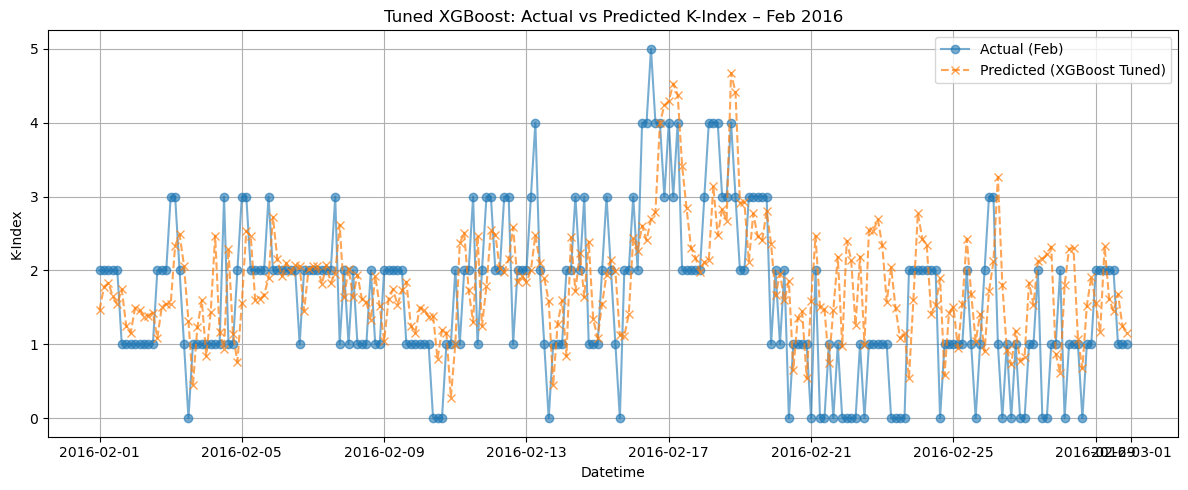

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# STEP 1: Long Format + Datetime Conversion
k_columns = [f'k{i}' for i in range(1, 9)]
k_long = df_k_cleaned.melt(id_vars='date', value_vars=k_columns,
                           var_name='interval', value_name='k_value_lag')

interval_map = {
    'k1': '00:00', 'k2': '03:00', 'k3': '06:00', 'k4': '09:00',
    'k5': '12:00', 'k6': '15:00', 'k7': '18:00', 'k8': '21:00'
}
k_long['time'] = k_long['interval'].map(interval_map)
k_long['datetime'] = pd.to_datetime(k_long['date'] + ' ' + k_long['time'])
k_long = k_long.sort_values('datetime').reset_index(drop=True)

# STEP 2: Filter Jan + Feb 2016
df_2016 = k_long[(k_long['datetime'] >= '2016-01-01') & (k_long['datetime'] < '2016-03-01')].copy()

#STEP 3: Create Lag Features
for lag in range(1, 9):
    df_2016[f'k_lag{lag}'] = df_2016['k_value_lag'].shift(lag)
df_2016 = df_2016.dropna().reset_index(drop=True)

# STEP 4: Train-Test Split
jan_df = df_2016[df_2016['datetime'] < '2016-02-01']
feb_df = df_2016[df_2016['datetime'] >= '2016-02-01']

X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]]
y_train = jan_df['k_value_lag']
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]]
y_test = feb_df['k_value_lag']

# STEP 5: Grid Search – XGBoost Regressor 
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_tuned = XGBRegressor(random_state=42, verbosity=0)
grid_search_xgb = GridSearchCV(xgb_tuned, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

best_xgb_tuned = grid_search_xgb.best_estimator_
y_pred_xgb_tuned = best_xgb_tuned.predict(X_test)

# STEP 6: Evaluation Metrics
RMSE_XGB_tuned = mean_squared_error(y_test, y_pred_xgb_tuned, squared=False)
MAE_XGB_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
R2_XGB_tuned = r2_score(y_test, y_pred_xgb_tuned)

print("Tuned XGBoost Evaluation (Lags 1–8):")
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"RMSE_XGB_tuned  = {RMSE_XGB_tuned:.4f}")
print(f"MAE_XGB_tuned   = {MAE_XGB_tuned:.4f}")
print(f"R²_XGB_tuned    = {R2_XGB_tuned:.4f}")

# STEP 7: Plot Actual vs Predicted
results_xgb_tuned = feb_df[['datetime']].copy()
results_xgb_tuned['actual_k'] = y_test.values
results_xgb_tuned['predicted_k_xgb_tuned'] = y_pred_xgb_tuned

plt.figure(figsize=(12, 5))
plt.plot(results_xgb_tuned['datetime'], results_xgb_tuned['actual_k'], label='Actual (Feb)', marker='o', linestyle='-', alpha=0.6)
plt.plot(results_xgb_tuned['datetime'], results_xgb_tuned['predicted_k_xgb_tuned'], label='Predicted (XGBoost Tuned)', marker='x', linestyle='--', alpha=0.7)
plt.title("Tuned XGBoost: Actual vs Predicted K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


Tuned Gradient Boosting Evaluation (Lags 1–8):
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
RMSE_GB_tuned  = 0.9147
MAE_GB_tuned   = 0.7263
R²_GB_tuned    = 0.2301


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


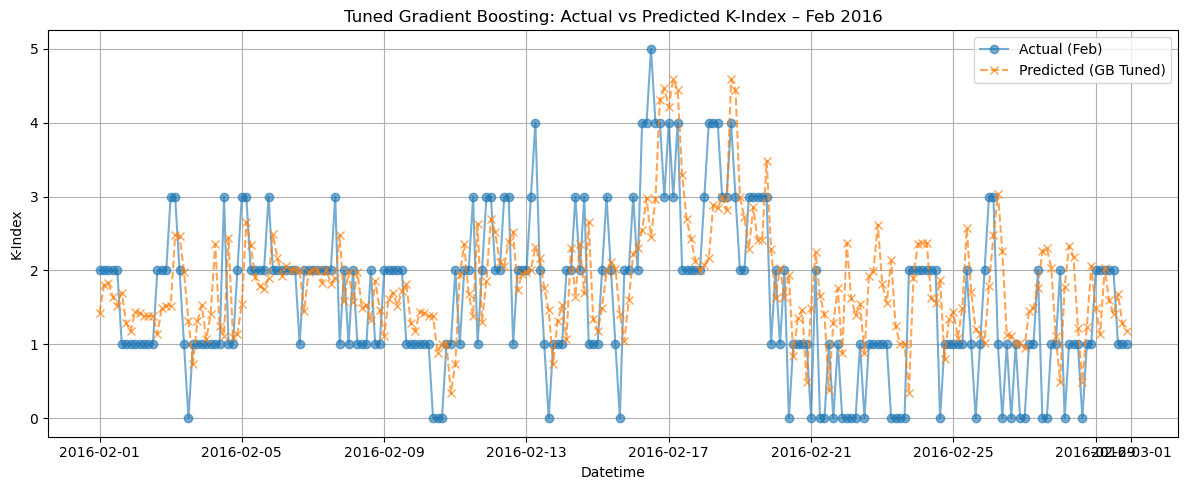

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Prepare Data
k_columns = [f'k{i}' for i in range(1, 9)]
k_long = df_k_cleaned.melt(id_vars='date', value_vars=k_columns,
                           var_name='interval', value_name='k_value_lag')

interval_map = {
    'k1': '00:00', 'k2': '03:00', 'k3': '06:00', 'k4': '09:00',
    'k5': '12:00', 'k6': '15:00', 'k7': '18:00', 'k8': '21:00'
}
k_long['time'] = k_long['interval'].map(interval_map)
k_long['datetime'] = pd.to_datetime(k_long['date'] + ' ' + k_long['time'])
k_long = k_long.sort_values('datetime').reset_index(drop=True)

# STEP 2: Filter Jan & Feb 2016
df_2016 = k_long[(k_long['datetime'] >= '2016-01-01') & (k_long['datetime'] < '2016-03-01')].copy()

# STEP 3: Create Lag Features
for lag in range(1, 9):
    df_2016[f'k_lag{lag}'] = df_2016['k_value_lag'].shift(lag)
df_2016 = df_2016.dropna().reset_index(drop=True)

# STEP 4: Split into Train (Jan) and Test (Feb)
jan_df = df_2016[df_2016['datetime'] < '2016-02-01']
feb_df = df_2016[df_2016['datetime'] >= '2016-02-01']

X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]]
y_train = jan_df['k_value_lag']
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]]
y_test = feb_df['k_value_lag']

# STEP 5: Grid Search – Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

gb_tuned = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(gb_tuned, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

best_gb_tuned = grid_search_gb.best_estimator_
y_pred_gb_tuned = best_gb_tuned.predict(X_test)

# STEP 6: Evaluation
RMSE_GB_tuned = mean_squared_error(y_test, y_pred_gb_tuned, squared=False)
MAE_GB_tuned = mean_absolute_error(y_test, y_pred_gb_tuned)
R2_GB_tuned = r2_score(y_test, y_pred_gb_tuned)

print("Tuned Gradient Boosting Evaluation (Lags 1–8):")
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"RMSE_GB_tuned  = {RMSE_GB_tuned:.4f}")
print(f"MAE_GB_tuned   = {MAE_GB_tuned:.4f}")
print(f"R²_GB_tuned    = {R2_GB_tuned:.4f}")

# STEP 7: Store Results
results_gb_tuned = feb_df[['datetime']].copy()
results_gb_tuned['actual_k'] = y_test.values
results_gb_tuned['predicted_k_gb_tuned'] = y_pred_gb_tuned

# STEP 8: Plot Actual vs Predicted
plt.figure(figsize=(12, 5))
plt.plot(results_gb_tuned['datetime'], results_gb_tuned['actual_k'], label='Actual (Feb)', marker='o', linestyle='-', alpha=0.6)
plt.plot(results_gb_tuned['datetime'], results_gb_tuned['predicted_k_gb_tuned'], label='Predicted (GB Tuned)', marker='x', linestyle='--', alpha=0.7)
plt.title("Tuned Gradient Boosting: Actual vs Predicted K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


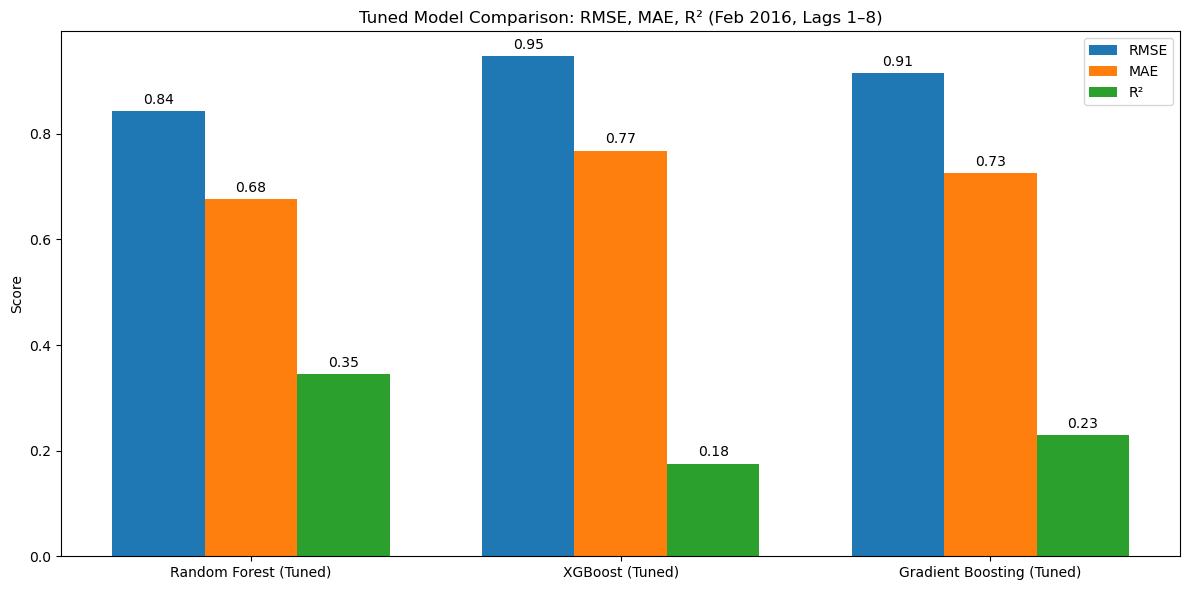

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
metrics = ['RMSE', 'MAE', 'R²']
models = ['Random Forest (Tuned)', 'XGBoost (Tuned)', 'Gradient Boosting (Tuned)']

# Metric values from previously computed tuned models
rmse_vals = [RMSE_RF_tuned, RMSE_XGB_tuned, RMSE_GB_tuned]
mae_vals = [MAE_RF_tuned, MAE_XGB_tuned, MAE_GB_tuned]
r2_vals = [R2_RF_tuned, R2_XGB_tuned, R2_GB_tuned]

# Combine metrics 
metrics_matrix = np.array([rmse_vals, mae_vals, r2_vals])

# Bar plot setup
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width, rmse_vals, width, label='RMSE')
bars2 = ax.bar(x, mae_vals, width, label='MAE')
bars3 = ax.bar(x + width, r2_vals, width, label='R²')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Final plot
ax.set_ylabel("Score")
ax.set_title("Tuned Model Comparison: RMSE, MAE, R² (Feb 2016, Lags 1–8)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


LSTM

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1813 - val_loss: 0.0310
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0742 - val_loss: 0.0152
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0312 - val_loss: 0.0171
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0182
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - val_loss: 0.0163
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0283 - val_loss: 0.0160
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290 - val_loss: 0.0159
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0164
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - val_loss: 0.0157
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - val_loss: 0.0163
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - val_loss: 0.0159
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252 - val_loss: 0.0159


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


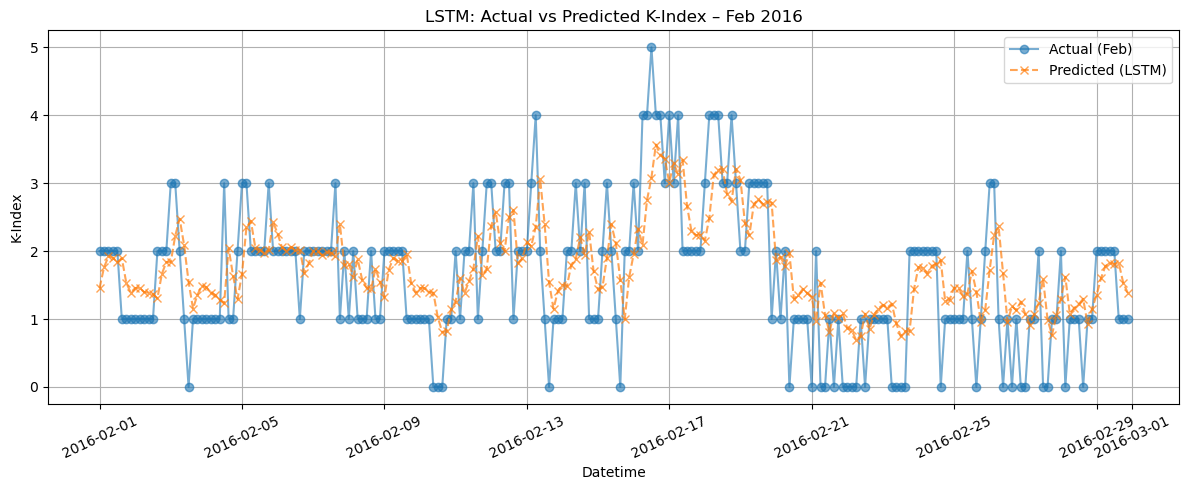

In [12]:
# === STEP 0: Import Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# STEP 1: Prepare Training & Test Data (from jan_df and feb_df)
X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]].values
y_train = jan_df['k_value_lag'].values
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]].values
y_test = feb_df['k_value_lag'].values

# STEP 2: Scale the Inputs and Outputs
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# STEP 3: Reshape Inputs for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# STEP 4: Build LSTM Model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# STEP 5: Train the Model
history = model.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=16, verbose=1, validation_split=0.1)

# STEP 6: Predict on Test Set
y_pred_scaled = model.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# STEP 7: Evaluation
RMSE_LSTM = mean_squared_error(y_test, y_pred, squared=False)
MAE_LSTM = mean_absolute_error(y_test, y_pred)
R2_LSTM = r2_score(y_test, y_pred)

print("LSTM Evaluation:")
print(f"RMSE_LSTM  : {RMSE_LSTM:.4f}")
print(f"MAE_LSTM   : {MAE_LSTM:.4f}")
print(f"R²_LSTM    : {R2_LSTM:.4f}")

# STEP 8: Store & Plot Predictions
results_lstm = feb_df[['datetime']].copy()
results_lstm['actual_k'] = y_test
results_lstm['predicted_k_lstm'] = y_pred.flatten()

plt.figure(figsize=(12, 5))
plt.plot(results_lstm['datetime'], results_lstm['actual_k'], label='Actual (Feb)', marker='o', linestyle='-', alpha=0.6)
plt.plot(results_lstm['datetime'], results_lstm['predicted_k_lstm'], label='Predicted (LSTM)', marker='x', linestyle='--', alpha=0.7)
plt.title("LSTM: Actual vs Predicted K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()


Probabilistic LSTM Forecast of K-Index with 95% Confidence Interval – February 2016

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1586 - val_loss: 0.0280
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540 - val_loss: 0.0138
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268 - val_loss: 0.0204
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - val_loss: 0.0159
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - val_loss: 0.0162
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255 - val_loss: 0.0182
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - val_loss: 0.0186
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242 - val_loss: 0.0165
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 - val_loss: 0.0148
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231 - val_loss: 0.0172
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0258 - val_loss: 0.0181
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - val_l

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Probabilistic LSTM (MC Dropout) Evaluation:
RMSE_LSTM_MC  : 0.7794
MAE_LSTM_MC   : 0.6168
R²_LSTM_MC    : 0.4410


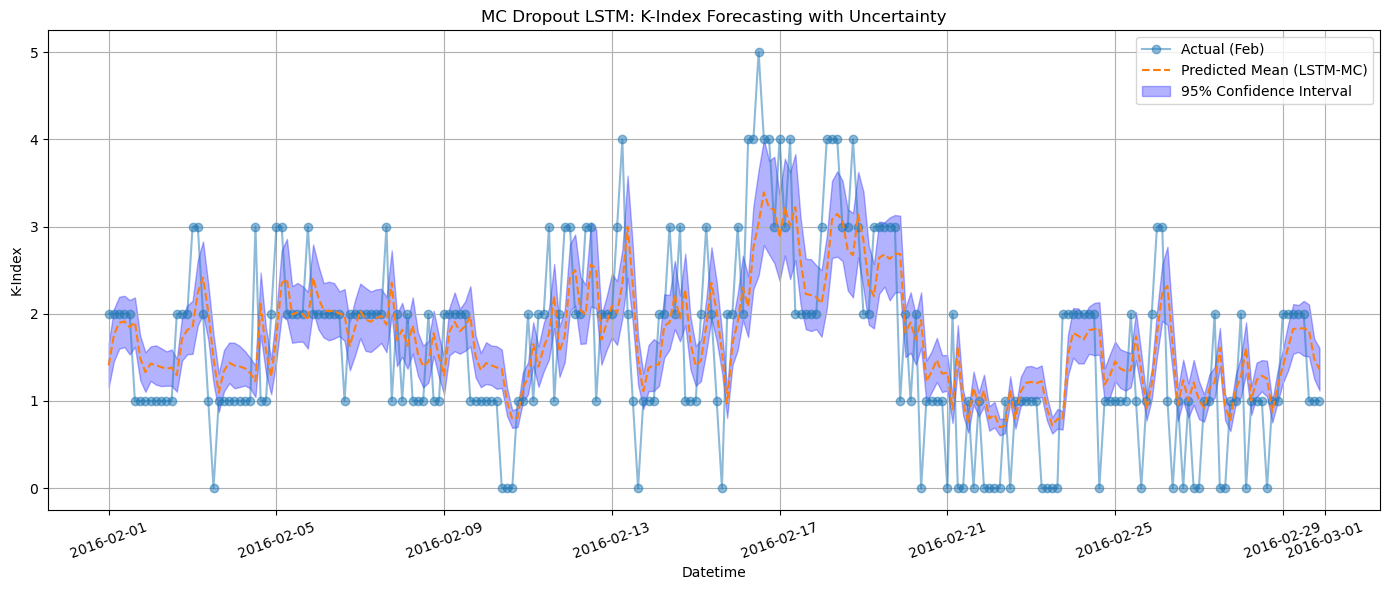

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Prepare Scaled Data
X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]].values
y_train = jan_df['k_value_lag'].values
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]].values
y_test = feb_df['k_value_lag'].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# STEP 2: Define Custom LSTM Model with Dropout Active at Inference
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

def build_mc_lstm(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=False)(inputs)
    x = MCDropout(0.3)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model_mc = build_mc_lstm((1, X_train_lstm.shape[2]))
model_mc.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# STEP 3: Monte Carlo Sampling Function
def monte_carlo_predictions(model, X_input, T=100):
    predictions = np.array([model(X_input, training=True).numpy().flatten() for _ in range(T)])
    return predictions

# STEP 4: Generate Predictions
mc_preds_scaled = monte_carlo_predictions(model_mc, X_test_lstm, T=100)
mean_preds_scaled = mc_preds_scaled.mean(axis=0)
std_preds_scaled = mc_preds_scaled.std(axis=0)

# STEP 5: Inverse Scaling
mean_preds = scaler_y.inverse_transform(mean_preds_scaled.reshape(-1, 1)).flatten()
lower_preds = scaler_y.inverse_transform((mean_preds_scaled - 1.96 * std_preds_scaled).reshape(-1, 1)).flatten()
upper_preds = scaler_y.inverse_transform((mean_preds_scaled + 1.96 * std_preds_scaled).reshape(-1, 1)).flatten()
actual = y_test

# STEP 6: Evaluation
RMSE_LSTM_MC = mean_squared_error(actual, mean_preds, squared=False)
MAE_LSTM_MC = mean_absolute_error(actual, mean_preds)
R2_LSTM_MC = r2_score(actual, mean_preds)

print("Probabilistic LSTM (MC Dropout) Evaluation:")
print(f"RMSE_LSTM_MC  : {RMSE_LSTM_MC:.4f}")
print(f"MAE_LSTM_MC   : {MAE_LSTM_MC:.4f}")
print(f"R²_LSTM_MC    : {R2_LSTM_MC:.4f}")

# STEP 7: Plot
results_mc = feb_df[['datetime']].copy()
results_mc['actual_k'] = actual
results_mc['predicted_k_mean'] = mean_preds
results_mc['lower_ci'] = lower_preds
results_mc['upper_ci'] = upper_preds

plt.figure(figsize=(14, 6))
plt.plot(results_mc['datetime'], results_mc['actual_k'], label='Actual (Feb)', alpha=0.5, marker='o')
plt.plot(results_mc['datetime'], results_mc['predicted_k_mean'], label='Predicted Mean (LSTM-MC)', linestyle='--')
plt.fill_between(results_mc['datetime'], results_mc['lower_ci'], results_mc['upper_ci'], alpha=0.3, color='blue', label='95% Confidence Interval')
plt.title("MC Dropout LSTM: K-Index Forecasting with Uncertainty")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()


Quantile Regression Evaluation (Median Prediction):
RMSE_QR  : 0.8650
MAE_QR   : 0.5892
R²_QR    : 0.3115


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


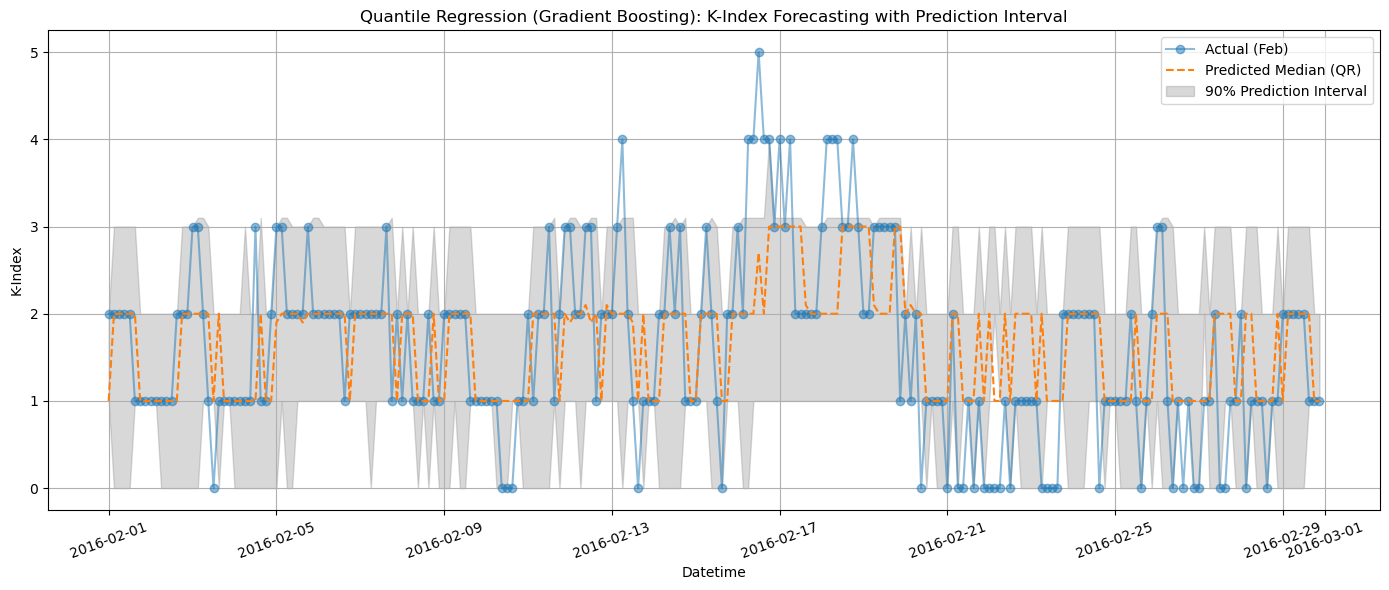

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#STEP 1: Prepare Long Format Data
k_columns = [f'k{i}' for i in range(1, 9)]
k_long = df_k_cleaned.melt(id_vars='date', value_vars=k_columns,
                           var_name='interval', value_name='k_value_lag')

interval_map = {
    'k1': '00:00', 'k2': '03:00', 'k3': '06:00', 'k4': '09:00',
    'k5': '12:00', 'k6': '15:00', 'k7': '18:00', 'k8': '21:00'
}
k_long['time'] = k_long['interval'].map(interval_map)
k_long['datetime'] = pd.to_datetime(k_long['date'] + ' ' + k_long['time'])
k_long = k_long.sort_values('datetime').reset_index(drop=True)

# STEP 2: Filter for Jan + Feb 2016
df_2016 = k_long[(k_long['datetime'] >= '2016-01-01') & (k_long['datetime'] < '2016-03-01')].copy()
for lag in range(1, 9):
    df_2016[f'k_lag{lag}'] = df_2016['k_value_lag'].shift(lag)
df_2016 = df_2016.dropna().reset_index(drop=True)

# STEP 3: Split Train/Test
jan_df = df_2016[df_2016['datetime'] < '2016-02-01']
feb_df = df_2016[df_2016['datetime'] >= '2016-02-01']

X_train = jan_df[[f'k_lag{i}' for i in range(1, 9)]].values
y_train = jan_df['k_value_lag'].values
X_test = feb_df[[f'k_lag{i}' for i in range(1, 9)]].values
y_test = feb_df['k_value_lag'].values

# STEP 4: Train Quantile Regression Models
quantiles = [0.05, 0.5, 0.95]
models = {}
predictions = {}

for q in quantiles:
    model = GradientBoostingRegressor(loss='quantile', alpha=q, n_estimators=100, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    models[q] = model
    predictions[q] = model.predict(X_test)

# STEP 5: Evaluation (Median Prediction)
rmse_qr = mean_squared_error(y_test, predictions[0.5], squared=False)
mae_qr = mean_absolute_error(y_test, predictions[0.5])
r2_qr = r2_score(y_test, predictions[0.5])

print("Quantile Regression Evaluation (Median Prediction):")
print(f"RMSE_QR  : {rmse_qr:.4f}")
print(f"MAE_QR   : {mae_qr:.4f}")
print(f"R²_QR    : {r2_qr:.4f}")

# STEP 6: Prepare Data for Plot
results_qr = feb_df[['datetime']].copy()
results_qr['actual_k'] = y_test
results_qr['lower_qr'] = predictions[0.05]
results_qr['median_qr'] = predictions[0.5]
results_qr['upper_qr'] = predictions[0.95]

# STEP 7: Plot
plt.figure(figsize=(14, 6))
plt.plot(results_qr['datetime'], results_qr['actual_k'], label='Actual (Feb)', alpha=0.5, marker='o')
plt.plot(results_qr['datetime'], results_qr['median_qr'], label='Predicted Median (QR)', linestyle='--')
plt.fill_between(results_qr['datetime'], results_qr['lower_qr'], results_qr['upper_qr'], alpha=0.3, color='gray', label='90% Prediction Interval')
plt.title("Quantile Regression (Gradient Boosting): K-Index Forecasting with Prediction Interval")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


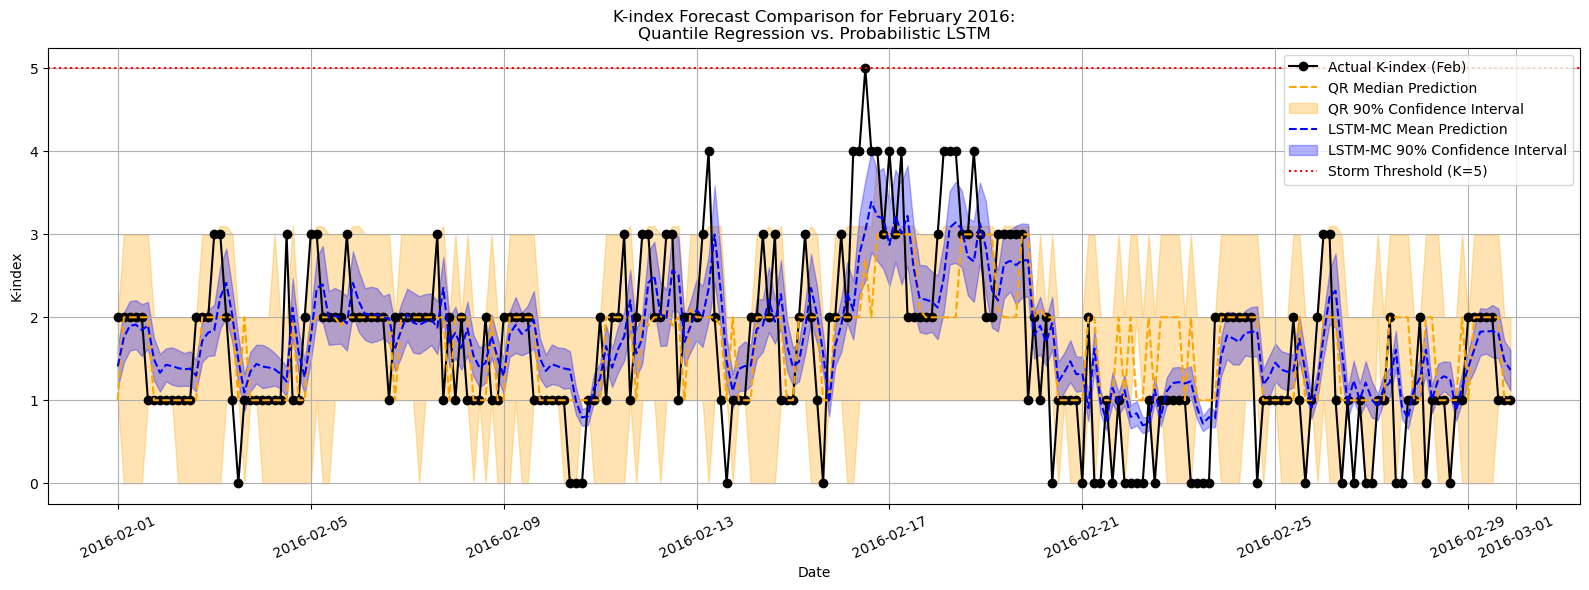

In [86]:
import matplotlib.pyplot as plt

# Plot Quantile Regression vs. Probabilistic LSTM
fig, ax = plt.subplots(figsize=(16, 6))

# Actual K-index
ax.plot(results_qr['datetime'], results_qr['actual_k'], 'o-', color='black', label='Actual K-index (Feb)')

# Quantile Regression predictions
ax.plot(results_qr['datetime'], results_qr['median_qr'], '--', color='orange', label='QR Median Prediction')
ax.fill_between(results_qr['datetime'], results_qr['lower_qr'], results_qr['upper_qr'],
                color='orange', alpha=0.3, label='QR 90% Confidence Interval')

# LSTM-MC predictions
ax.plot(results_mc['datetime'], results_mc['predicted_k_mean'], '--', color='blue', label='LSTM-MC Mean Prediction')
ax.fill_between(results_mc['datetime'], results_mc['lower_ci'], results_mc['upper_ci'],
                color='blue', alpha=0.3, label='LSTM-MC 90% Confidence Interval')

# Storm threshold
ax.axhline(y=5, color='red', linestyle=':', label='Storm Threshold (K=5)')

ax.set_title("K-index Forecast Comparison for February 2016:\nQuantile Regression vs. Probabilistic LSTM")
ax.set_xlabel("Date")
ax.set_ylabel("K-index")
ax.grid(True)
plt.xticks(rotation=25)
ax.legend()
plt.tight_layout()
plt.show()


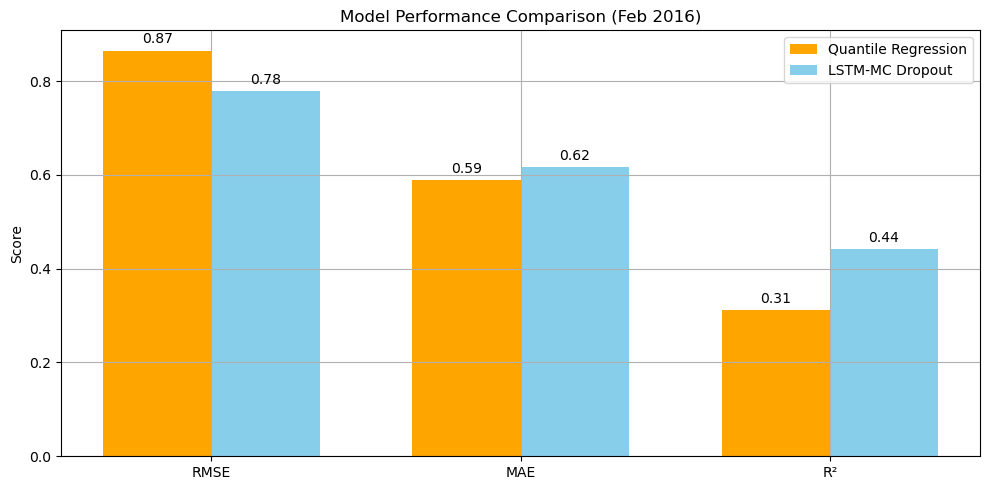

In [87]:
import matplotlib.pyplot as plt

rmse_qr = rmse_qr
mae_qr = mae_qr
r2_qr = r2_qr

RMSE_LSTM_MC = RMSE_LSTM_MC
MAE_LSTM_MC = MAE_LSTM_MC
R2_LSTM_MC = R2_LSTM_MC

# Plotting
metrics = ['RMSE', 'MAE', 'R²']
qr_scores = [rmse_qr, mae_qr, r2_qr]
lstm_scores = [RMSE_LSTM_MC, MAE_LSTM_MC, R2_LSTM_MC]

x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar([i - width/2 for i in x], qr_scores, width, label='Quantile Regression', color='orange')
bars2 = ax.bar([i + width/2 for i in x], lstm_scores, width, label='LSTM-MC Dropout', color='skyblue')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison (Feb 2016)')
ax.set_xticks(x)
ax.grid(True)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


=============================================================================================================================================

Dataframe for K-index for Magnetic Field Modelling.

In [17]:
import pandas as pd
import numpy as np

# Step 1: Load the CSV
file_path = "/Users/dhruvsharma/Desktop/Stats/Project/df_k_cleaned.csv"
k_df = pd.read_csv(file_path)

# Step 2: Define the k-index columns (3-hour intervals)
k_columns = ["k1", "k2", "k3", "k4", "k5", "k6", "k7", "k8"]
k_df[k_columns] = k_df[k_columns].astype(float)  # no rounding, preserve decimals


if 'k_value' in k_df.columns:
    k_df = k_df.drop(columns=['k_value'])

# Step 3: Melt to long format
k_long = k_df.melt(
    id_vars=["date"], 
    value_vars=k_columns,
    var_name="interval",
    value_name="k_value"
)

# Step 4: Map interval to 3-hour offset
k_long["interval_num"] = k_long["interval"].str.extract("(\d+)").astype(int)
k_long["hour_offset"] = (k_long["interval_num"] - 1) * 3

# Step 5: Compute true datetime 
k_long["datetime"] = pd.to_datetime(k_long["date"]) + pd.to_timedelta(k_long["hour_offset"], unit="h")

# Step 6: Final cleanup
k_long = k_long.sort_values("datetime").reset_index(drop=True)

# Step 7: Preview 
print("3-hourly K-index data preview:")
print(k_long.head(16))
print("Range:", k_long["datetime"].min(), "→", k_long["datetime"].max())
print("Total records:", len(k_long))
print("Missing K values:", k_long["k_value"].isna().sum())


3-hourly K-index data preview:
          date interval  k_value  interval_num  hour_offset  \
0   2016-01-01       k1      3.0             1            0   
1   2016-01-01       k2      4.0             2            3   
2   2016-01-01       k3      3.0             3            6   
3   2016-01-01       k4      2.0             4            9   
4   2016-01-01       k5      2.0             5           12   
5   2016-01-01       k6      0.0             6           15   
6   2016-01-01       k7      2.0             7           18   
7   2016-01-01       k8      2.0             8           21   
8   2016-01-02       k1      3.0             1            0   
9   2016-01-02       k2      2.0             2            3   
10  2016-01-02       k3      3.0             3            6   
11  2016-01-02       k4      2.0             4            9   
12  2016-01-02       k5      2.0             5           12   
13  2016-01-02       k6      2.0             6           15   
14  2016-01-02       k7 

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_43020/3126179688.py:25: SyntaxWarning: invalid escape sequence '\d'
  k_long["interval_num"] = k_long["interval"].str.extract("(\d+)").astype(int)


Resampling of the Magnetic Field Data.

In [18]:
import pandas as pd

# Load the magnetic field data
mag_path = "/Users/dhruvsharma/Desktop/Stats/Project/eyrxyz2016_fil_reduced.csv"
mag_df = pd.read_csv(mag_path)

mag_df.columns = ["date", "eyrx", "eyry"]
mag_df["date"] = pd.to_datetime(mag_df["date"], errors="coerce")

# Check for parsing failures
if mag_df["date"].isna().all():
    raise ValueError("All date values failed to parse. Please check the actual format of 'date' column.")

# Create synthetic time assuming 1 row per minute
mag_df["datetime"] = pd.date_range(start=mag_df["date"].min(), periods=len(mag_df), freq="T")

# Drop the old date column
mag_df.drop(columns="date", inplace=True)

# Set datetime index and resample to 3-hour blocks
mag_df.set_index("datetime", inplace=True)
mag_df_3h = mag_df.resample("3H").mean().dropna().reset_index()

mag_df_3h["eyrx"] = mag_df_3h["eyrx"].round(2)
mag_df_3h["eyry"] = mag_df_3h["eyry"].round(2)

# Preview result
print("Resampling successful!")
print("Start:", mag_df_3h["datetime"].min())
print("End:", mag_df_3h["datetime"].max())
print("Total rows:", len(mag_df_3h))
display(mag_df_3h.head())

Resampling successful!
Start: 2016-01-01 00:00:00
End: 2016-12-31 21:00:00
Total rows: 2928


/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_43020/443248368.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mag_df["date"] = pd.to_datetime(mag_df["date"], errors="coerce")
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_43020/443248368.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mag_df["datetime"] = pd.date_range(start=mag_df["date"].min(), periods=len(mag_df), freq="T")
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_43020/443248368.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mag_df_3h = mag_df.resample("3H").mean().dropna().reset_index()


datetime      eyrx     eyry
0 2016-01-01 00:00:00  19200.13  8425.24
1 2016-01-01 03:00:00  19253.15  8430.60
2 2016-01-01 06:00:00  19236.92  8410.30
3 2016-01-01 09:00:00  19238.62  8406.70
4 2016-01-01 12:00:00  19235.36  8430.18

Merging the K-index and Magnetic Filed Data

In [19]:
# Merge on 3-hour datetime
merged_df = pd.merge(k_long, mag_df_3h, on="datetime", how="inner")

# Drop rows with any missing values
merged_df = merged_df.dropna().reset_index(drop=True)

# Preview result 
print("Merge successful.")
print("Total merged rows:", len(merged_df))
display(merged_df.head(20))

Merge successful.
Total merged rows: 2928


date interval  k_value  interval_num  hour_offset  \
0   2016-01-01       k1      3.0             1            0   
1   2016-01-01       k2      4.0             2            3   
2   2016-01-01       k3      3.0             3            6   
3   2016-01-01       k4      2.0             4            9   
4   2016-01-01       k5      2.0             5           12   
5   2016-01-01       k6      0.0             6           15   
6   2016-01-01       k7      2.0             7           18   
7   2016-01-01       k8      2.0             8           21   
8   2016-01-02       k1      3.0             1            0   
9   2016-01-02       k2      2.0             2            3   
10  2016-01-02       k3      3.0             3            6   
11  2016-01-02       k4      2.0             4            9   
12  2016-01-02       k5      2.0             5           12   
13  2016-01-02       k6      2.0             6           15   
14  2016-01-02       k7      2.0             7           18   
15  2016-01-02       k8      1.0             8           21   
16  2016-01-03       k1      1.0             1            0   
17  2016-01-03       k2      3.0             2            3   
18  2016-01-03       k3      2.0             3            6   
19  2016-01-03       k4      2.0             4            9   

              datetime      eyrx     eyry  
0  2016-01-01 00:00:00  19200.13  8425.24  
1  2016-01-01 03:00:00  19253.15  8430.60  
2  2016-01-01 06:00:00  19236.92  8410.30  
3  2016-01-01 09:00:00  19238.62  8406.70  
4  2016-01-01 12:00:00  19235.36  8430.18  
5  2016-01-01 15:00:00  19237.29  8425.47  
6  2016-01-01 18:00:00  19246.12  8406.56  
7  2016-01-01 21:00:00  19243.29  8397.62  
8  2016-01-02 00:00:00  19231.95  8439.35  
9  2016-01-02 03:00:00  19261.74  8457.55  
10 2016-01-02 06:00:00  19269.54  8451.44  
11 2016-01-02 09:00:00  19269.04  8429.29  
12 2016-01-02 12:00:00  19256.13  8427.47  
13 2016-01-02 15:00:00  19253.57  8420.30  
14 2016-01-02 18:00:00  19253.65  8398.37  
15 2016-01-02 21:00:00  19238.37  8421.30  
16 2016-01-03 00:00:00  19231.89  8464.46  
17 2016-01-03 03:00:00  19269.59  8472.65  
18 2016-01-03 06:00:00  19265.39  8453.73  
19 2016-01-03 09:00:00  19256.11  8447.52

Linear Regression using K-index and Magnetic Field Data

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


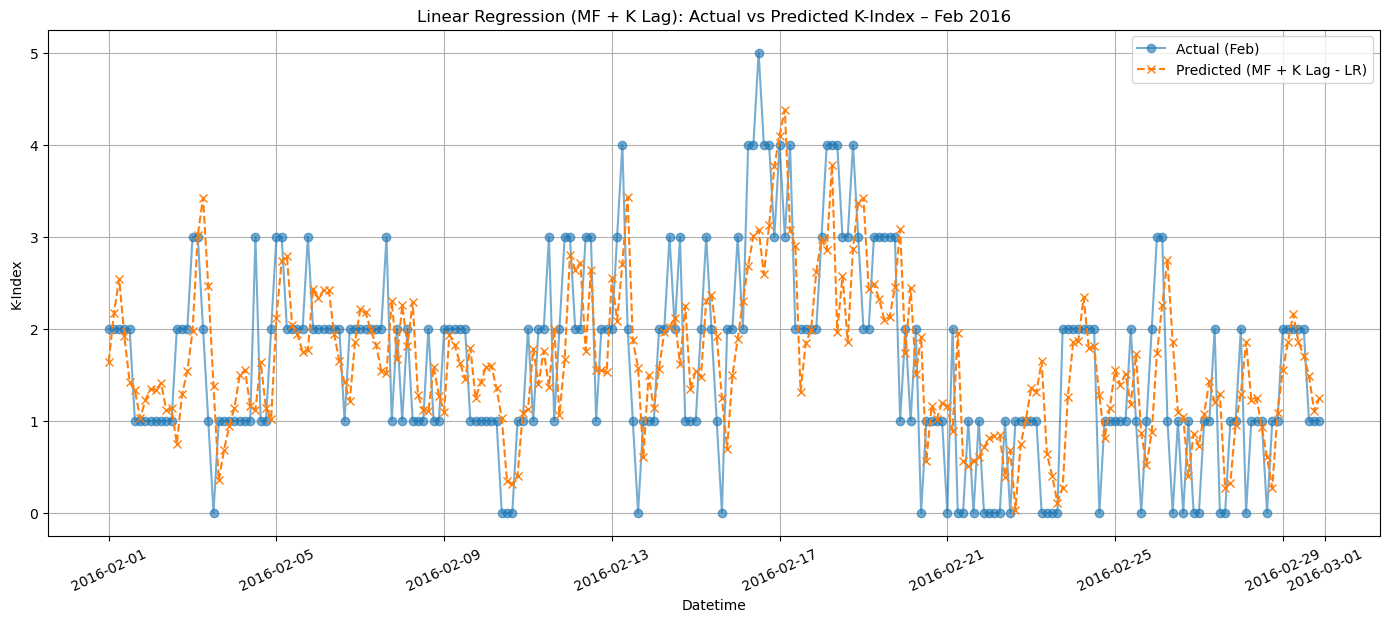


Evaluation Metrics for Linear Regression (Magnetic Field + K-Lag, Jan → Feb 2016):
RMSE_MF_K_LR  = 0.8033
MAE_MF_K_LR   = 0.6400
R²_MF_K_LR    = 0.4063


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Generate combined lag features (K + Magnetic Field)
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)


merged_df_combined = merged_df.dropna().reset_index(drop=True)

#STEP 2: Split Jan for training, Feb for testing
jan_data = merged_df_combined[(merged_df_combined["datetime"] >= "2016-01-01") & 
                               (merged_df_combined["datetime"] < "2016-02-01")]
feb_data = merged_df_combined[(merged_df_combined["datetime"] >= "2016-02-01") & 
                               (merged_df_combined["datetime"] < "2016-03-01")]

# Define feature columns
k_lags = [f"k_lag{i}" for i in range(1, 9)]
eyrx_lags = [f"eyrx_lag{i}" for i in range(1, 9)]
eyry_lags = [f"eyry_lag{i}" for i in range(1, 9)]
all_features = k_lags + eyrx_lags + eyry_lags

# Extract features and labels
X_train = jan_data[all_features]
y_train = jan_data["k_value"]
X_test = feb_data[all_features]
y_test = feb_data["k_value"]

# STEP 3: Train the Linear Regression model 
model_combined_lr = LinearRegression()
model_combined_lr.fit(X_train, y_train)
y_pred = model_combined_lr.predict(X_test)

# STEP 4: Evaluate Model
RMSE_MF_K_LR = mean_squared_error(y_test, y_pred, squared=False)
MAE_MF_K_LR = mean_absolute_error(y_test, y_pred)
R2_MF_K_LR = r2_score(y_test, y_pred)

# STEP 5: Plot
results_combined = feb_data[["datetime"]].copy()
results_combined["actual_k"] = y_test.values
results_combined["predicted_k_mf_klr"] = y_pred

plt.figure(figsize=(14, 6))
plt.plot(results_combined["datetime"], results_combined["actual_k"], label="Actual (Feb)", alpha=0.6, marker='o')
plt.plot(results_combined["datetime"], results_combined["predicted_k_mf_klr"], label="Predicted (MF + K Lag - LR)", linestyle='--', marker='x')
plt.title("Linear Regression (MF + K Lag): Actual vs Predicted K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=25)
plt.show()

# STEP 6: Print Evaluation Metrics
print("\nEvaluation Metrics for Linear Regression (Magnetic Field + K-Lag, Jan → Feb 2016):")
print(f"RMSE_MF_K_LR  = {RMSE_MF_K_LR:.4f}")
print(f"MAE_MF_K_LR   = {MAE_MF_K_LR:.4f}")
print(f"R²_MF_K_LR    = {R2_MF_K_LR:.4f}")


Random Forest using K-index and Magnetic Field Data

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


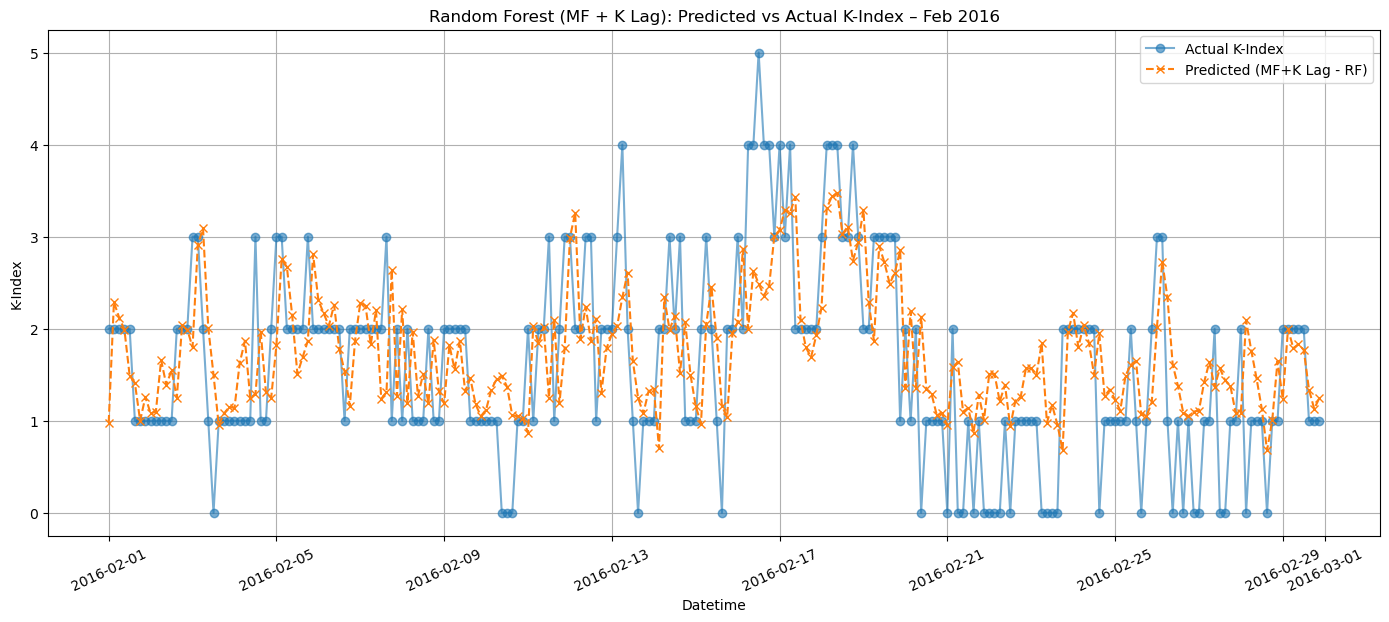


Random Forest Evaluation (MF + K Lag, Jan → Feb 2016):
RMSE_MF_K_RF = 0.8406
MAE_MF_K_RF  = 0.6535
R²_MF_K_RF   = 0.3499


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Generate lag features
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)


merged_df_combined = merged_df.dropna().reset_index(drop=True)

# STEP 2: Filter Jan for training, Feb for testing 
jan_data = merged_df_combined[(merged_df_combined["datetime"] >= "2016-01-01") &
                               (merged_df_combined["datetime"] < "2016-02-01")]
feb_data = merged_df_combined[(merged_df_combined["datetime"] >= "2016-02-01") &
                               (merged_df_combined["datetime"] < "2016-03-01")]

# STEP 3: Prepare features
k_lags = [f"k_lag{i}" for i in range(1, 9)]
eyrx_lags = [f"eyrx_lag{i}" for i in range(1, 9)]
eyry_lags = [f"eyry_lag{i}" for i in range(1, 9)]
all_features = k_lags + eyrx_lags + eyry_lags

X_train = jan_data[all_features]
y_train = jan_data["k_value"]
X_test = feb_data[all_features]
y_test = feb_data["k_value"]

# STEP 4: Train model
model_rf_combined = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_combined.fit(X_train, y_train)
y_pred_rf = model_rf_combined.predict(X_test)

# STEP 5: Evaluation
RMSE_MF_K_RF = mean_squared_error(y_test, y_pred_rf, squared=False)
MAE_MF_K_RF = mean_absolute_error(y_test, y_pred_rf)
R2_MF_K_RF = r2_score(y_test, y_pred_rf)

# STEP 6: Plot
results_rf = feb_data[["datetime"]].copy()
results_rf["actual_k"] = y_test.values
results_rf["predicted_k_rf"] = y_pred_rf

plt.figure(figsize=(14, 6))
plt.plot(results_rf["datetime"], results_rf["actual_k"], label="Actual K-Index", marker='o', alpha=0.6)
plt.plot(results_rf["datetime"], results_rf["predicted_k_rf"], label="Predicted (MF+K Lag - RF)", marker='x', linestyle='--')
plt.title("Random Forest (MF + K Lag): Predicted vs Actual K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=25)
plt.show()

# STEP 7: Print Metrics
print("\nRandom Forest Evaluation (MF + K Lag, Jan → Feb 2016):")
print(f"RMSE_MF_K_RF = {RMSE_MF_K_RF:.4f}")
print(f"MAE_MF_K_RF  = {MAE_MF_K_RF:.4f}")
print(f"R²_MF_K_RF   = {R2_MF_K_RF:.4f}")


XGBoost using K-index and Magnetic Field Data

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


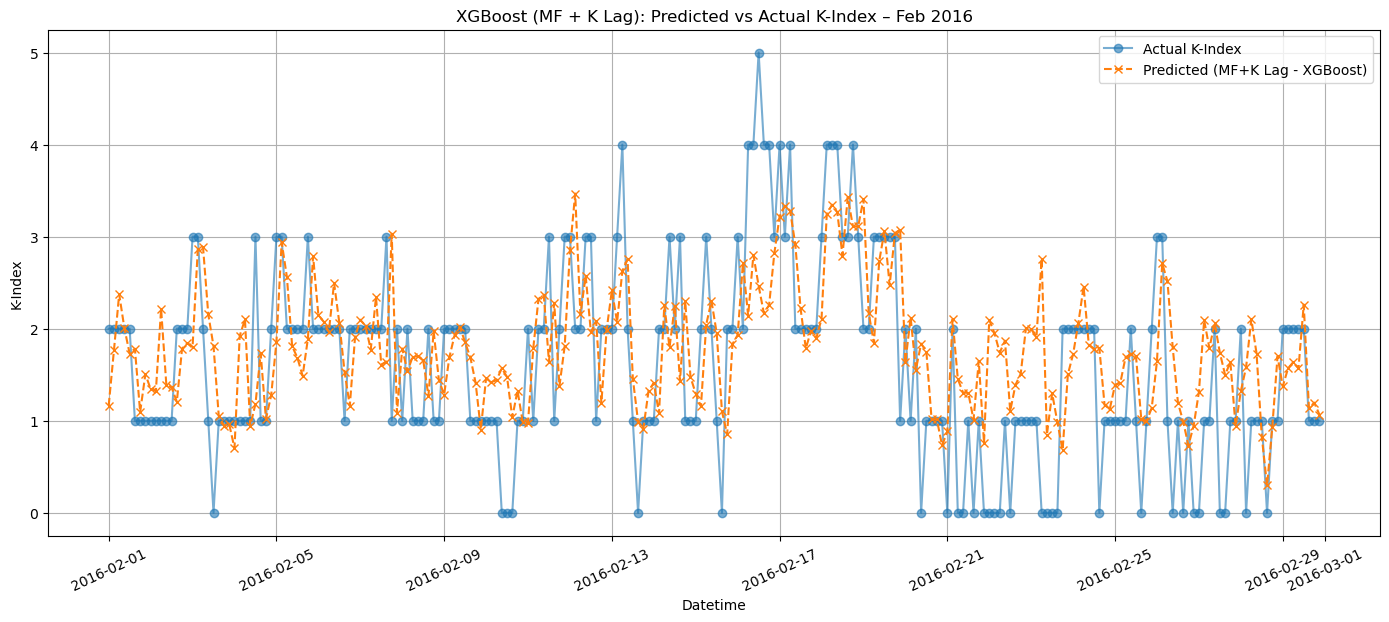


 XGBoost Evaluation (MF + K Lag, Jan → Feb 2016):
RMSE_MF_K_XGB = 0.8754
MAE_MF_K_XGB  = 0.6849
R²_MF_K_XGB   = 0.2949


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Generate lag features
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)

# Drop rows with missing lag values
merged_df_combined = merged_df.dropna().reset_index(drop=True)

# STEP 2: Split Jan for training, Feb for testing
jan_data = merged_df_combined[(merged_df_combined["datetime"] >= "2016-01-01") &
                               (merged_df_combined["datetime"] < "2016-02-01")]
feb_data = merged_df_combined[(merged_df_combined["datetime"] >= "2016-02-01") &
                               (merged_df_combined["datetime"] < "2016-03-01")]

# STEP 3: Prepare features
k_lags = [f"k_lag{i}" for i in range(1, 9)]
eyrx_lags = [f"eyrx_lag{i}" for i in range(1, 9)]
eyry_lags = [f"eyry_lag{i}" for i in range(1, 9)]
all_features = k_lags + eyrx_lags + eyry_lags

X_train = jan_data[all_features]
y_train = jan_data["k_value"]
X_test = feb_data[all_features]
y_test = feb_data["k_value"]

# STEP 4: Train the XGBoost model
model_xgb_combined = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_xgb_combined.fit(X_train, y_train)
y_pred_xgb = model_xgb_combined.predict(X_test)

# STEP 5: Evaluation 
RMSE_MF_K_XGB = mean_squared_error(y_test, y_pred_xgb, squared=False)
MAE_MF_K_XGB = mean_absolute_error(y_test, y_pred_xgb)
R2_MF_K_XGB = r2_score(y_test, y_pred_xgb)

# STEP 6: Plot results
results_xgb = feb_data[["datetime"]].copy()
results_xgb["actual_k"] = y_test.values
results_xgb["predicted_k_xgb"] = y_pred_xgb

plt.figure(figsize=(14, 6))
plt.plot(results_xgb["datetime"], results_xgb["actual_k"], label="Actual K-Index", marker='o', alpha=0.6)
plt.plot(results_xgb["datetime"], results_xgb["predicted_k_xgb"], label="Predicted (MF+K Lag - XGBoost)", marker='x', linestyle='--')
plt.title("XGBoost (MF + K Lag): Predicted vs Actual K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=25)
plt.show()

# STEP 7: Print Evaluation Metrics
print("\n XGBoost Evaluation (MF + K Lag, Jan → Feb 2016):")
print(f"RMSE_MF_K_XGB = {RMSE_MF_K_XGB:.4f}")
print(f"MAE_MF_K_XGB  = {MAE_MF_K_XGB:.4f}")
print(f"R²_MF_K_XGB   = {R2_MF_K_XGB:.4f}")


Gradient Boosting using K-value and Magnetic Field Data

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


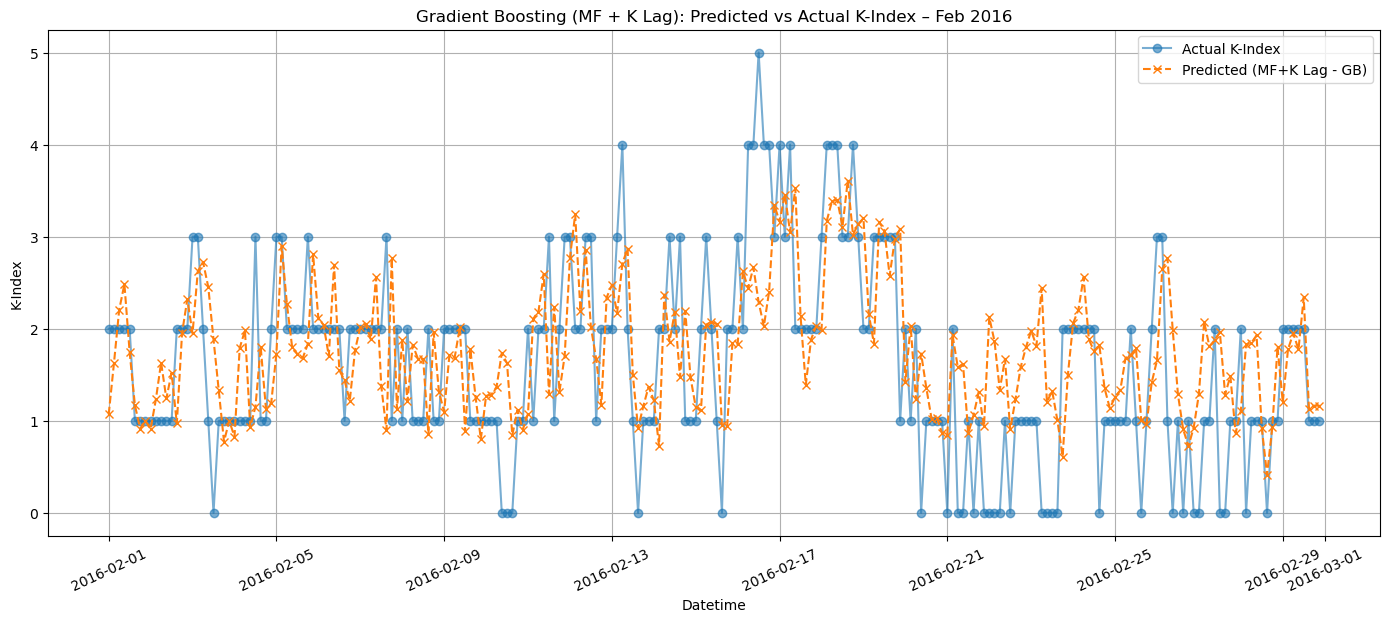


 Gradient Boosting Evaluation (MF + K Lag, Jan → Feb 2016):
RMSE_MF_K_GB = 0.8935
MAE_MF_K_GB  = 0.6971
R²_MF_K_GB   = 0.2653


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# STEP 1: Generate lag features
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)

# Drop rows with missing lag values
merged_df_combined = merged_df.dropna().reset_index(drop=True)

# STEP 2: Split Jan for training, Feb for testing
jan_data = merged_df_combined[(merged_df_combined["datetime"] >= "2016-01-01") &
                               (merged_df_combined["datetime"] < "2016-02-01")]
feb_data = merged_df_combined[(merged_df_combined["datetime"] >= "2016-02-01") &
                               (merged_df_combined["datetime"] < "2016-03-01")]

# STEP 3: Feature setup
k_lags = [f"k_lag{i}" for i in range(1, 9)]
eyrx_lags = [f"eyrx_lag{i}" for i in range(1, 9)]
eyry_lags = [f"eyry_lag{i}" for i in range(1, 9)]
all_features = k_lags + eyrx_lags + eyry_lags

X_train = jan_data[all_features]
y_train = jan_data["k_value"]
X_test = feb_data[all_features]
y_test = feb_data["k_value"]

# STEP 4: Train Gradient Boosting
model_gb_combined = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gb_combined.fit(X_train, y_train)
y_pred_gb = model_gb_combined.predict(X_test)

# STEP 5: Evaluation Metrics
RMSE_MF_K_GB = mean_squared_error(y_test, y_pred_gb, squared=False)
MAE_MF_K_GB = mean_absolute_error(y_test, y_pred_gb)
R2_MF_K_GB = r2_score(y_test, y_pred_gb)

# STEP 6: Plot results
results_gb = feb_data[["datetime"]].copy()
results_gb["actual_k"] = y_test.values
results_gb["predicted_k_gb"] = y_pred_gb

plt.figure(figsize=(14, 6))
plt.plot(results_gb["datetime"], results_gb["actual_k"], label="Actual K-Index", marker='o', alpha=0.6)
plt.plot(results_gb["datetime"], results_gb["predicted_k_gb"], label="Predicted (MF+K Lag - GB)", marker='x', linestyle='--')
plt.title("Gradient Boosting (MF + K Lag): Predicted vs Actual K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=25)
plt.show()

# STEP 7: Print Evaluation Metrics
print("\n Gradient Boosting Evaluation (MF + K Lag, Jan → Feb 2016):")
print(f"RMSE_MF_K_GB = {RMSE_MF_K_GB:.4f}")
print(f"MAE_MF_K_GB  = {MAE_MF_K_GB:.4f}")
print(f"R²_MF_K_GB   = {R2_MF_K_GB:.4f}")


Comparison Plot. 

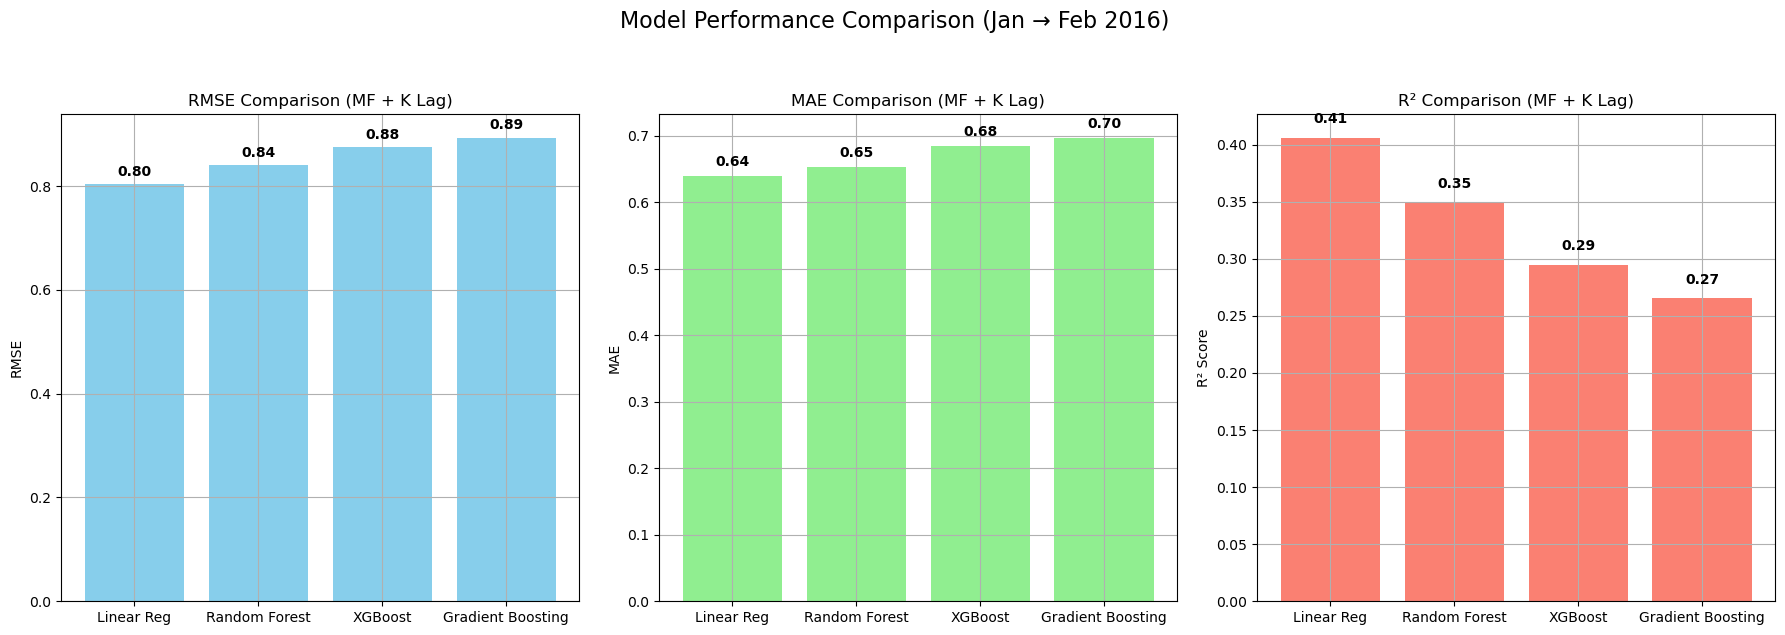

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
model_names = ['Linear Reg', 'Random Forest', 'XGBoost', 'Gradient Boosting']

try:
    rmse_values = [RMSE_MF_K_LR, RMSE_MF_K_RF, RMSE_MF_K_XGB, RMSE_MF_K_GB]
    mae_values = [MAE_MF_K_LR, MAE_MF_K_RF, MAE_MF_K_XGB, MAE_MF_K_GB]
    r2_values  = [R2_MF_K_LR, R2_MF_K_RF, R2_MF_K_XGB, R2_MF_K_GB]
except NameError:
    print(" One or more metric variables not found. Please ensure all model metrics are defined.")
    rmse_values = mae_values = r2_values = [0, 0, 0, 0]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot RMSE
axes[0].bar(model_names, rmse_values, color='skyblue')
axes[0].set_title("RMSE Comparison (MF + K Lag)")
axes[0].set_ylabel("RMSE")
for i, v in enumerate(rmse_values):
    axes[0].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
axes[0].grid(True)

# Plot MAE
axes[1].bar(model_names, mae_values, color='lightgreen')
axes[1].set_title("MAE Comparison (MF + K Lag)")
axes[1].set_ylabel("MAE")
for i, v in enumerate(mae_values):
    axes[1].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
axes[1].grid(True)

# Plot R²
axes[2].bar(model_names, r2_values, color='salmon')
axes[2].set_title("R² Comparison (MF + K Lag)")
axes[2].set_ylabel("R² Score")
for i, v in enumerate(r2_values):
    axes[2].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
axes[2].grid(True)

# Final layout tweaks
plt.suptitle("Model Performance Comparison (Jan → Feb 2016)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


Hyperparameter Tunning

Random Forest (K+MF)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


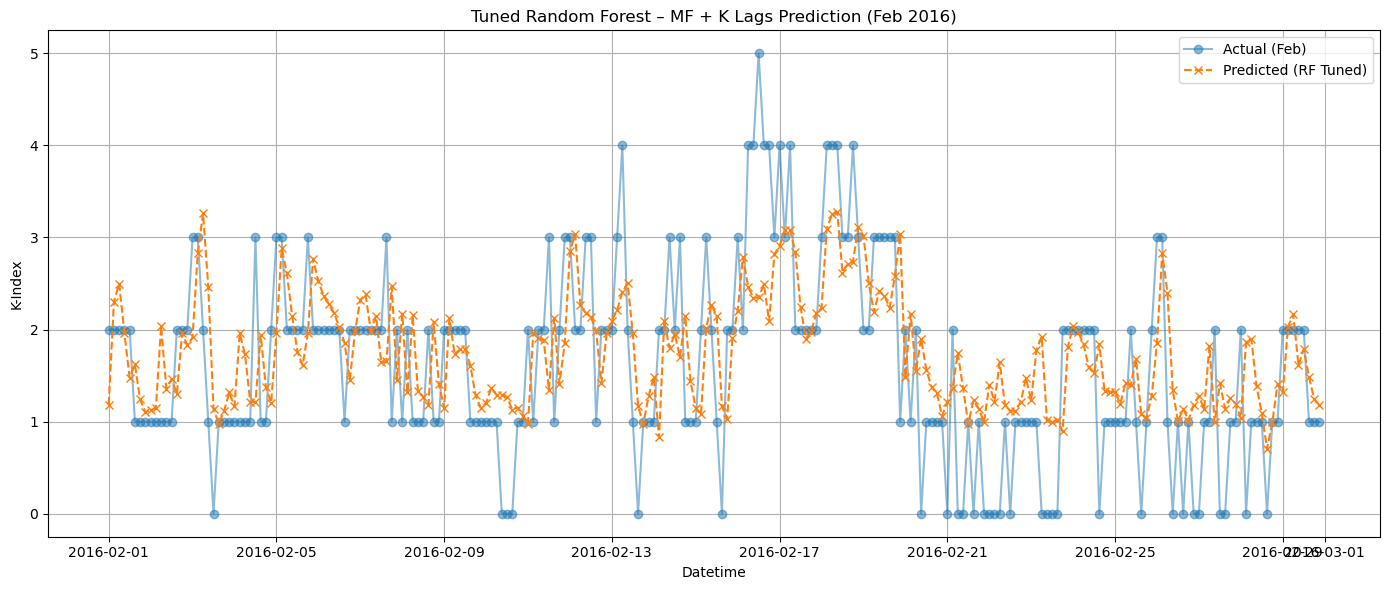


 Tuned Random Forest Evaluation (Jan → Feb 2016):
Best Parameters        : {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
RMSE_MF_K_RF_TUNED     = 0.8331
MAE_MF_K_RF_TUNED      = 0.6555
R²_MF_K_RF_TUNED       = 0.3613


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Generate lag features
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)

merged_df = merged_df.dropna().reset_index(drop=True)

# Step 2: Split data
train_data = merged_df[(merged_df["datetime"] >= "2016-01-01") & (merged_df["datetime"] < "2016-02-01")]
test_data  = merged_df[(merged_df["datetime"] >= "2016-02-01") & (merged_df["datetime"] < "2016-03-01")]

X_train = train_data[[f"k_lag{i}" for i in range(1, 9)] +
                     [f"eyrx_lag{i}" for i in range(1, 9)] +
                     [f"eyry_lag{i}" for i in range(1, 9)]]
y_train = train_data["k_value"]

X_test = test_data[[f"k_lag{i}" for i in range(1, 9)] +
                   [f"eyrx_lag{i}" for i in range(1, 9)] +
                   [f"eyry_lag{i}" for i in range(1, 9)]]
y_test = test_data["k_value"]

# Step 3: Grid Search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

# Step 4: Predict
y_pred = best_rf.predict(X_test)

RMSE_MF_K_RF_TUNED = mean_squared_error(y_test, y_pred, squared=False)
MAE_MF_K_RF_TUNED  = mean_absolute_error(y_test, y_pred)
R2_MF_K_RF_TUNED   = r2_score(y_test, y_pred)

# Step 5: Plot
results_MF_K_RF_TUNED = test_data[["datetime"]].copy()
results_MF_K_RF_TUNED["actual_k_rf_tuned"] = y_test.values
results_MF_K_RF_TUNED["predicted_k_rf_tuned"] = y_pred

plt.figure(figsize=(14, 6))
plt.plot(results_MF_K_RF_TUNED["datetime"], results_MF_K_RF_TUNED["actual_k_rf_tuned"],
         label="Actual (Feb)", marker='o', alpha=0.5)
plt.plot(results_MF_K_RF_TUNED["datetime"], results_MF_K_RF_TUNED["predicted_k_rf_tuned"],
         label="Predicted (RF Tuned)", linestyle='--', marker='x')
plt.title("Tuned Random Forest – MF + K Lags Prediction (Feb 2016)")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

# Step 6: Print Results
print("\n Tuned Random Forest Evaluation (Jan → Feb 2016):")
print(f"Best Parameters        : {grid_search.best_params_}")
print(f"RMSE_MF_K_RF_TUNED     = {RMSE_MF_K_RF_TUNED:.4f}")
print(f"MAE_MF_K_RF_TUNED      = {MAE_MF_K_RF_TUNED:.4f}")
print(f"R²_MF_K_RF_TUNED       = {R2_MF_K_RF_TUNED:.4f}")


Tuned XGBoost (K+MF) 

Train size: 232
Test size: 232
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


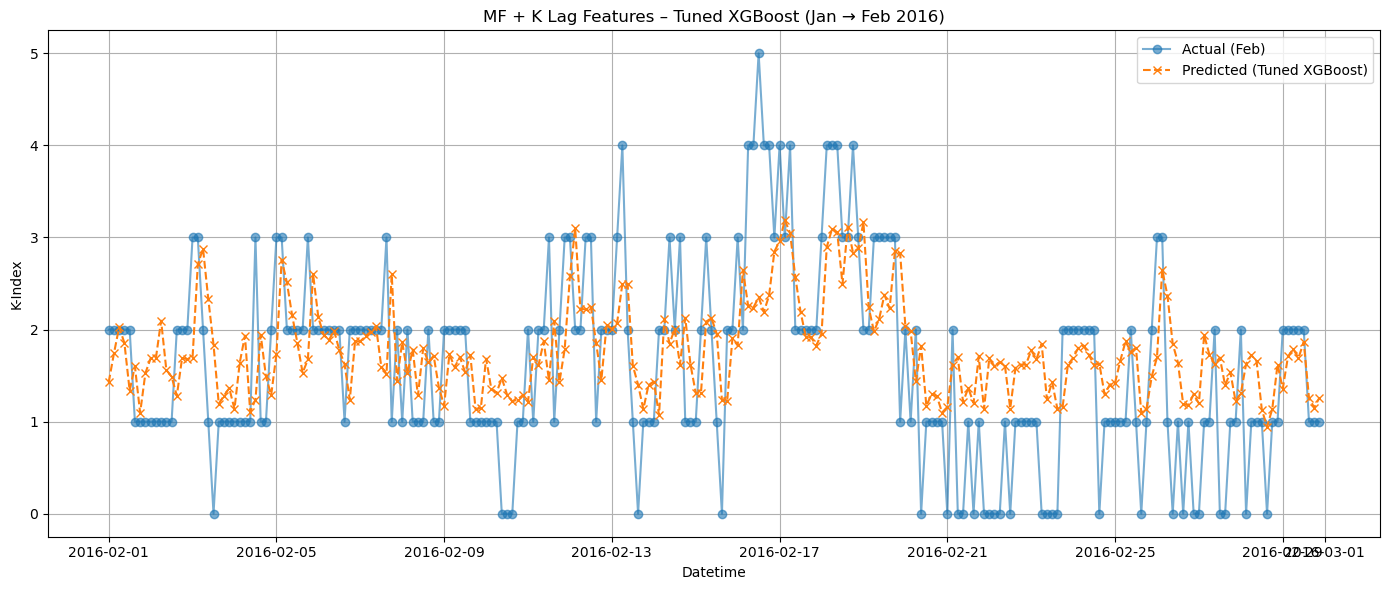


 Tuned XGBoost Evaluation (MF + K Lag):
Best Parameters         : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
RMSE_MF_K_XGB_TUNED     = 0.8579
MAE_MF_K_XGB_TUNED      = 0.6903
R²_MF_K_XGB_TUNED       = 0.3228


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

merged_df["datetime"] = pd.to_datetime(merged_df["datetime"], errors="coerce")
merged_df = merged_df.dropna(subset=["datetime"])

# Create lag features 
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)

merged_df = merged_df.dropna().reset_index(drop=True)

# Train on Jan, Predict on Feb
train_data = merged_df[(merged_df["datetime"] >= "2016-01-01") & (merged_df["datetime"] < "2016-02-01")]
test_data  = merged_df[(merged_df["datetime"] >= "2016-02-01") & (merged_df["datetime"] < "2016-03-01")]

X_train = train_data[[f"k_lag{i}" for i in range(1, 9)] +
                     [f"eyrx_lag{i}" for i in range(1, 9)] +
                     [f"eyry_lag{i}" for i in range(1, 9)]]
y_train = train_data["k_value"]

X_test = test_data[[f"k_lag{i}" for i in range(1, 9)] +
                   [f"eyrx_lag{i}" for i in range(1, 9)] +
                   [f"eyry_lag{i}" for i in range(1, 9)]]
y_test = test_data["k_value"]


print("Train size:", len(X_train))
print("Test size:", len(X_test))

# Grid Search on XGBoost
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

grid = GridSearchCV(
    xgb,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)

# Evaluate 
RMSE_MF_K_XGB_TUNED = mean_squared_error(y_test, y_pred, squared=False)
MAE_MF_K_XGB_TUNED = mean_absolute_error(y_test, y_pred)
R2_MF_K_XGB_TUNED = r2_score(y_test, y_pred)

# Plot results
results_df = test_data[["datetime"]].copy()
results_df["actual_k"] = y_test.values
results_df["predicted_k"] = y_pred

plt.figure(figsize=(14, 6))
plt.plot(results_df["datetime"], results_df["actual_k"], label="Actual (Feb)", marker='o', alpha=0.6)
plt.plot(results_df["datetime"], results_df["predicted_k"], label="Predicted (Tuned XGBoost)", marker='x', linestyle='--')
plt.title("MF + K Lag Features – Tuned XGBoost (Jan → Feb 2016)")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Metrics
print("\n Tuned XGBoost Evaluation (MF + K Lag):")
print("Best Parameters         :", grid.best_params_)
print(f"RMSE_MF_K_XGB_TUNED     = {RMSE_MF_K_XGB_TUNED:.4f}")
print(f"MAE_MF_K_XGB_TUNED      = {MAE_MF_K_XGB_TUNED:.4f}")
print(f"R²_MF_K_XGB_TUNED       = {R2_MF_K_XGB_TUNED:.4f}")


Tuned Gradient Boosting (K+MF)

 Training Samples: 224
 Testing Samples : 232
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


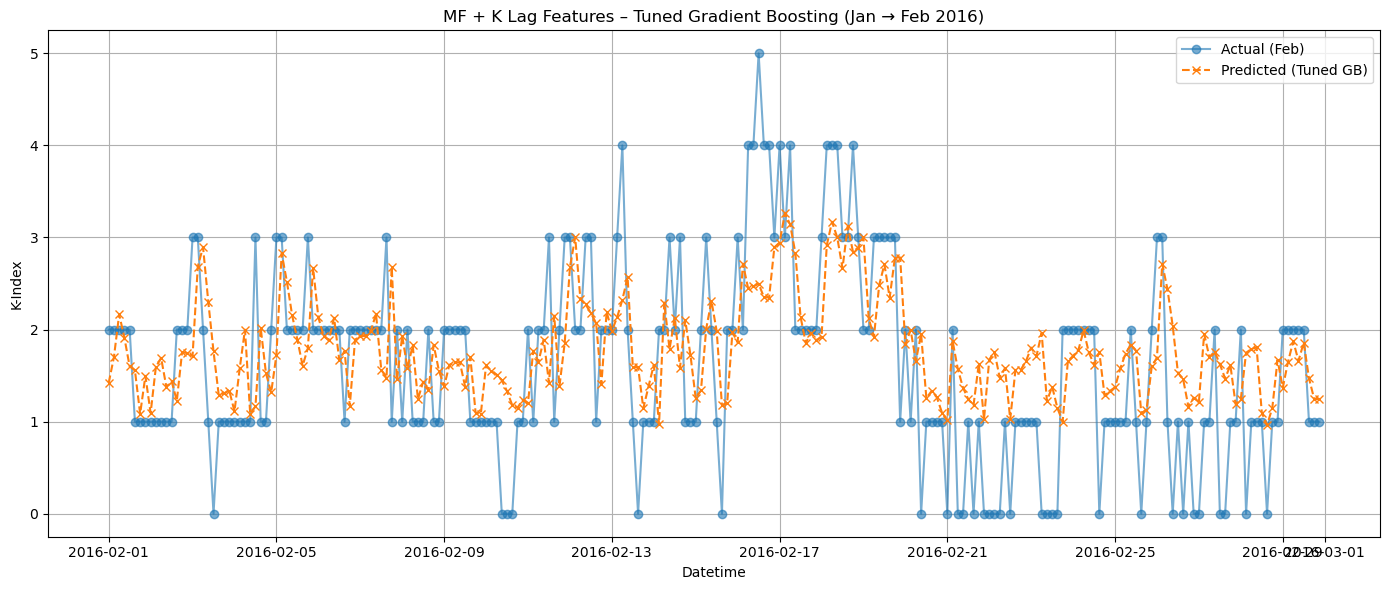


 Tuned Gradient Boosting Evaluation (MF + K Lag):
Best Parameters          : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
RMSE_MF_K_GB_TUNED       = 0.8570
MAE_MF_K_GB_TUNED        = 0.6857
R²_MF_K_GB_TUNED         = 0.3242


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

merged_df["datetime"] = pd.to_datetime(merged_df["datetime"], errors="coerce")
merged_df = merged_df.dropna(subset=["datetime"])

# Create lag features
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)

merged_df = merged_df.dropna().reset_index(drop=True)

# Filter for Jan (train) and Feb (test)
train_data = merged_df[(merged_df["datetime"] >= "2016-01-01") & (merged_df["datetime"] < "2016-02-01")]
test_data  = merged_df[(merged_df["datetime"] >= "2016-02-01") & (merged_df["datetime"] < "2016-03-01")]

X_train = train_data[[f"k_lag{i}" for i in range(1, 9)] +
                     [f"eyrx_lag{i}" for i in range(1, 9)] +
                     [f"eyry_lag{i}" for i in range(1, 9)]]
y_train = train_data["k_value"]

X_test = test_data[[f"k_lag{i}" for i in range(1, 9)] +
                   [f"eyrx_lag{i}" for i in range(1, 9)] +
                   [f"eyry_lag{i}" for i in range(1, 9)]]
y_test = test_data["k_value"]

# Check dataset sizes
print(" Training Samples:", X_train.shape[0])
print(" Testing Samples :", X_test.shape[0])

# Grid Search Parameters
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1]
}

gb = GradientBoostingRegressor(random_state=42)
grid = GridSearchCV(
    gb,
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_gb = grid.best_estimator_
y_pred = best_gb.predict(X_test)

# Evaluation Metrics
RMSE_MF_K_GB_TUNED = mean_squared_error(y_test, y_pred, squared=False)
MAE_MF_K_GB_TUNED = mean_absolute_error(y_test, y_pred)
R2_MF_K_GB_TUNED = r2_score(y_test, y_pred)

# Plot Predictions vs Actual
results_df = test_data[["datetime"]].copy()
results_df["actual_k"] = y_test.values
results_df["predicted_k"] = y_pred

plt.figure(figsize=(14, 6))
plt.plot(results_df["datetime"], results_df["actual_k"], label="Actual (Feb)", marker='o', alpha=0.6)
plt.plot(results_df["datetime"], results_df["predicted_k"], label="Predicted (Tuned GB)", marker='x', linestyle='--')
plt.title("MF + K Lag Features – Tuned Gradient Boosting (Jan → Feb 2016)")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print Metrics
print("\n Tuned Gradient Boosting Evaluation (MF + K Lag):")
print("Best Parameters          :", grid.best_params_)
print(f"RMSE_MF_K_GB_TUNED       = {RMSE_MF_K_GB_TUNED:.4f}")
print(f"MAE_MF_K_GB_TUNED        = {MAE_MF_K_GB_TUNED:.4f}")
print(f"R²_MF_K_GB_TUNED         = {R2_MF_K_GB_TUNED:.4f}")


Tuned Model Performance Comparison using Kvalue - K value + MF

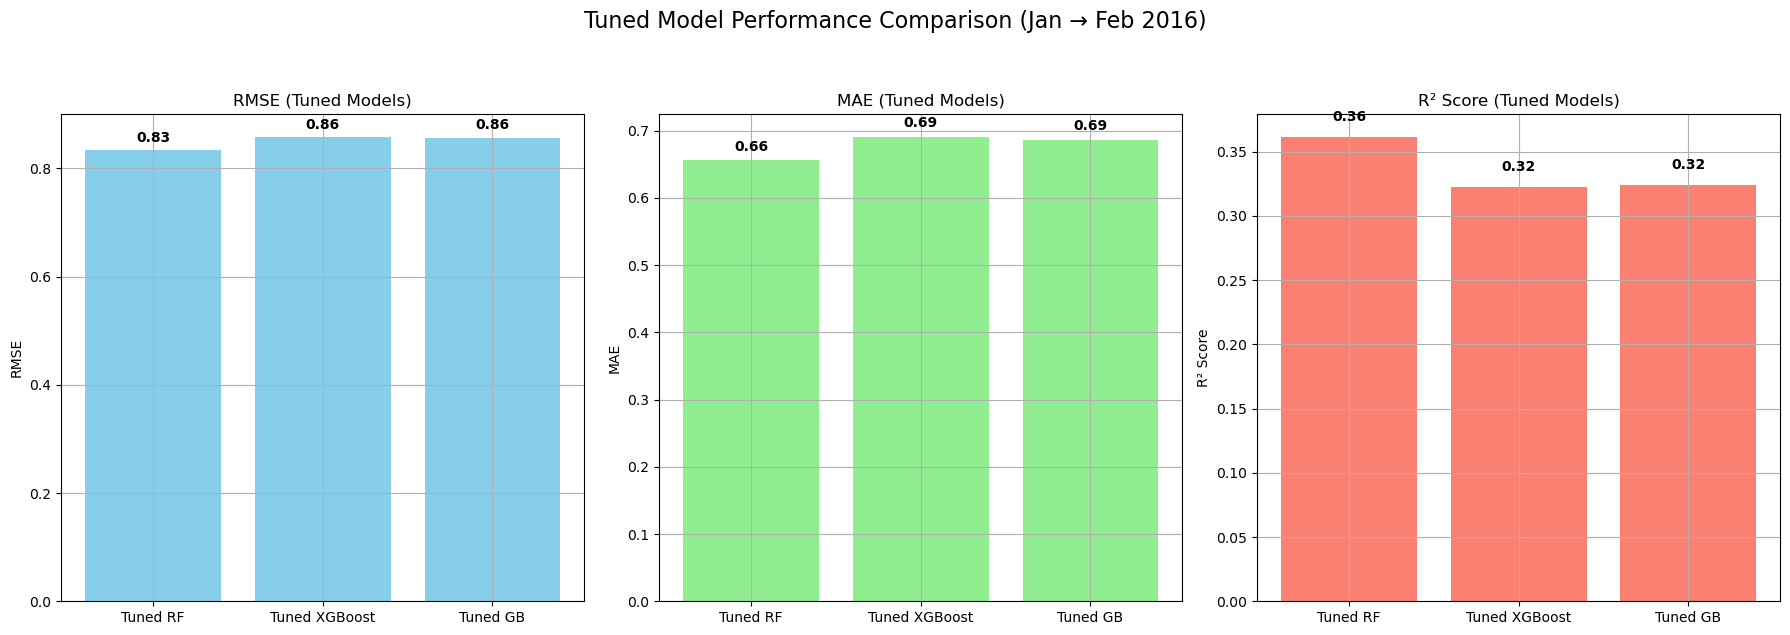

In [66]:
import matplotlib.pyplot as plt

# Define model labels
model_names = ["Tuned RF", "Tuned XGBoost", "Tuned GB"]


try:
    rmse_values = [RMSE_MF_K_RF_TUNED, RMSE_MF_K_XGB_TUNED, RMSE_MF_K_GB_TUNED]
    mae_values  = [MAE_MF_K_RF_TUNED, MAE_MF_K_XGB_TUNED, MAE_MF_K_GB_TUNED]
    r2_values   = [R2_MF_K_RF_TUNED, R2_MF_K_XGB_TUNED, R2_MF_K_GB_TUNED]
except NameError as e:
    raise RuntimeError(" One or more tuned metric variables are missing. Please run model training first.") from e

# Set up the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE Plot
axes[0].bar(model_names, rmse_values, color='skyblue')
axes[0].set_title("RMSE (Tuned Models)")
axes[0].set_ylabel("RMSE")
for i, v in enumerate(rmse_values):
    axes[0].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
axes[0].grid(True)

# MAE Plot
axes[1].bar(model_names, mae_values, color='lightgreen')
axes[1].set_title("MAE (Tuned Models)")
axes[1].set_ylabel("MAE")
for i, v in enumerate(mae_values):
    axes[1].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
axes[1].grid(True)

# R² Plot
axes[2].bar(model_names, r2_values, color='salmon')
axes[2].set_title("R² Score (Tuned Models)")
axes[2].set_ylabel("R² Score")
for i, v in enumerate(r2_values):
    axes[2].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontweight='bold')
axes[2].grid(True)

# Final layout adjustments
plt.suptitle("Tuned Model Performance Comparison (Jan → Feb 2016)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


LSTM using K value +MF (Magnetic Field)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


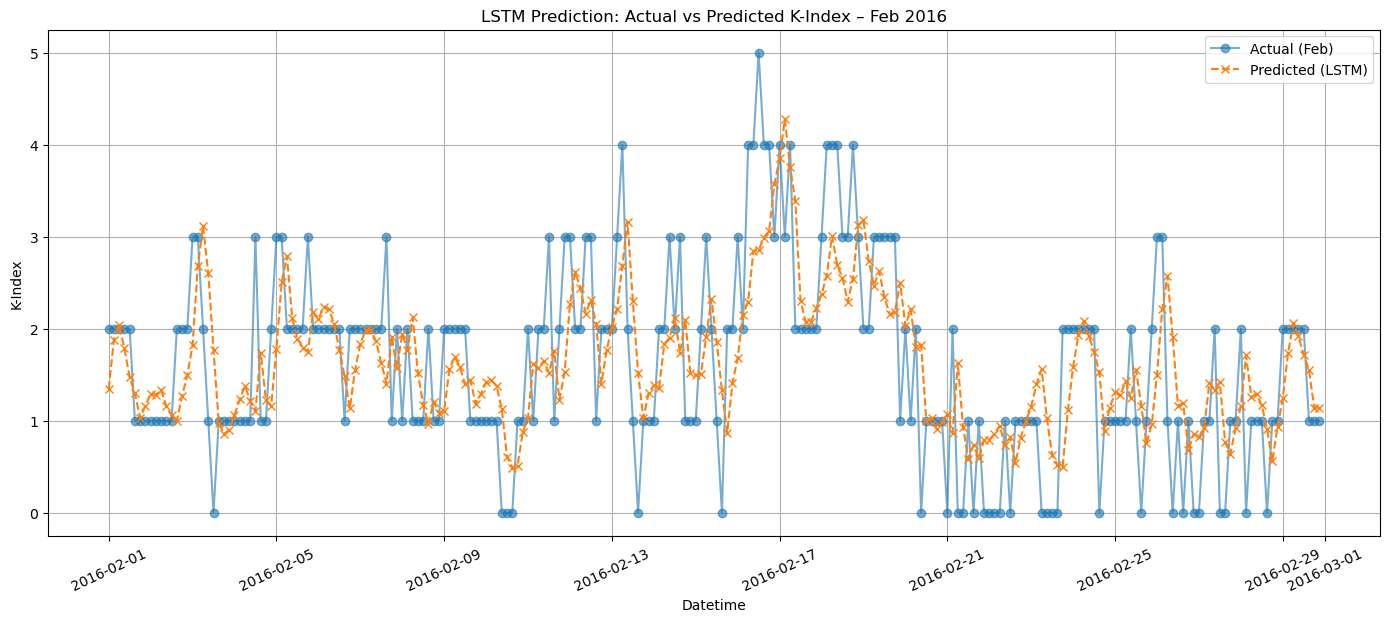

LSTM Evaluation with K-lag + MF-lag (Jan → Feb 2016):
RMSE_MF_K_LSTM = 0.7905
MAE_MF_K_LSTM  = 0.6216
R²_MF_K_LSTM   = 0.4250


In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Generate lag features
merged_df_lstm = merged_df.copy()
for lag in range(1, 9):
    merged_df_lstm[f"k_lag{lag}"] = merged_df_lstm["k_value"].shift(lag)
    merged_df_lstm[f"eyrx_lag{lag}"] = merged_df_lstm["eyrx"].shift(lag)
    merged_df_lstm[f"eyry_lag{lag}"] = merged_df_lstm["eyry"].shift(lag)

merged_df_lstm.dropna(inplace=True)
merged_df_lstm.reset_index(drop=True, inplace=True)

# Split into Jan and Feb
jan_data = merged_df_lstm[(merged_df_lstm["datetime"] >= "2016-01-01") & (merged_df_lstm["datetime"] < "2016-02-01")]
feb_data = merged_df_lstm[(merged_df_lstm["datetime"] >= "2016-02-01") & (merged_df_lstm["datetime"] < "2016-03-01")]

# Define features and target
feature_cols = [f"k_lag{i}" for i in range(1, 9)] + [f"eyrx_lag{i}" for i in range(1, 9)] + [f"eyry_lag{i}" for i in range(1, 9)]
X_train = jan_data[feature_cols].values
X_test = feb_data[feature_cols].values
y_train = jan_data["k_value"].values
y_test = feb_data["k_value"].values

# Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for LSTM [samples, time steps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define and train LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_scaled, epochs=50, batch_size=16, verbose=0)

# Predict and inverse transform
y_pred_scaled = model_lstm.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluate
RMSE_MF_K_LSTM = mean_squared_error(y_test, y_pred, squared=False)
MAE_MF_K_LSTM = mean_absolute_error(y_test, y_pred)
R2_MF_K_LSTM = r2_score(y_test, y_pred)

# Prepare results for plotting
results_lstm = feb_data[["datetime"]].copy()
results_lstm["actual_k"] = y_test
results_lstm["predicted_k_lstm"] = y_pred.flatten()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(results_lstm["datetime"], results_lstm["actual_k"], label="Actual (Feb)", alpha=0.6, marker='o')
plt.plot(results_lstm["datetime"], results_lstm["predicted_k_lstm"], label="Predicted (LSTM)", linestyle='--', marker='x')
plt.title("LSTM Prediction: Actual vs Predicted K-Index – Feb 2016")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=25)
plt.show()

# Print Metrics
print("LSTM Evaluation with K-lag + MF-lag (Jan → Feb 2016):")
print(f"RMSE_MF_K_LSTM = {RMSE_MF_K_LSTM:.4f}")
print(f"MAE_MF_K_LSTM  = {MAE_MF_K_LSTM:.4f}")
print(f"R²_MF_K_LSTM   = {R2_MF_K_LSTM:.4f}")


LSTM with Monte Carlo Dropout

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Monte Carlo Dropout LSTM Evaluation (MF + K Lag):
RMSE_MF_K_MC  : 0.8371
MAE_MF_K_MC   : 0.6684
R²_MF_K_MC    : 0.3552


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


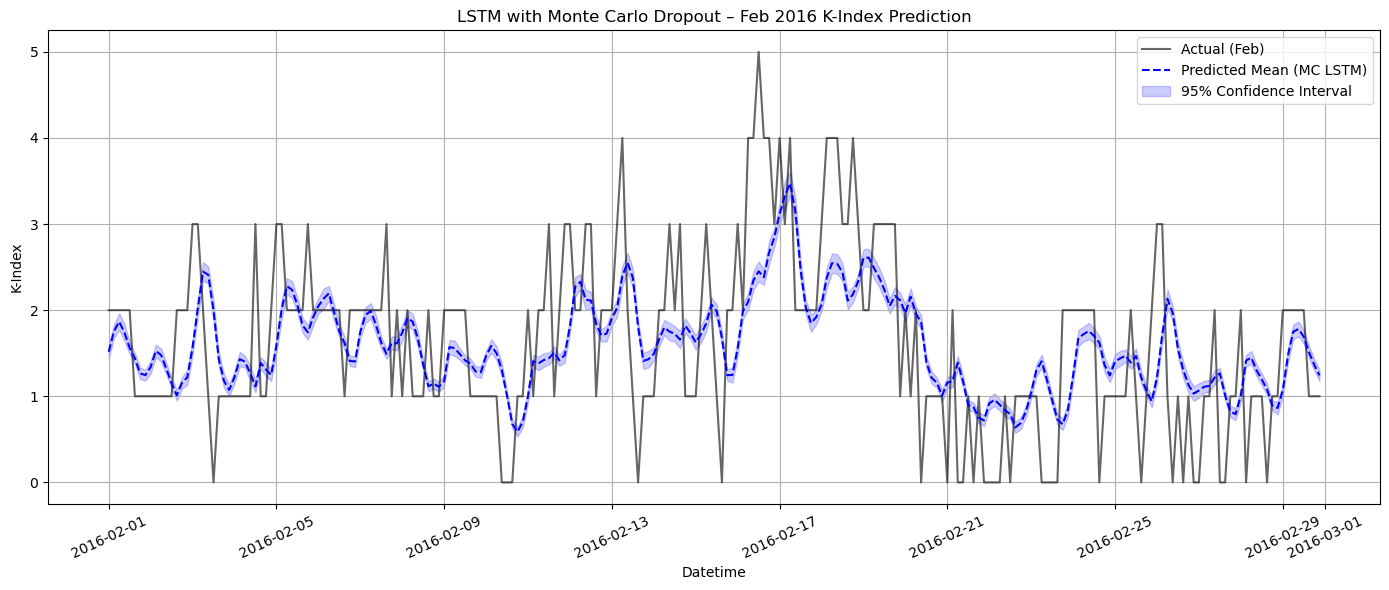

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Create lag features for k_value, eyrx, eyry
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)

merged_df = merged_df.dropna().reset_index(drop=True)

# Select features and target
feature_cols = [f"k_lag{i}" for i in range(1, 9)] + [f"eyrx_lag{i}" for i in range(1, 9)] + [f"eyry_lag{i}" for i in range(1, 9)]
target_col = "k_value"

# Train: Jan 2016, Test: Feb 2016
train_df = merged_df[(merged_df["datetime"] >= "2016-01-01") & (merged_df["datetime"] < "2016-02-01")]
test_df = merged_df[(merged_df["datetime"] >= "2016-02-01") & (merged_df["datetime"] < "2016-03-01")]

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(train_df[feature_cols])
y_train = scaler_y.fit_transform(train_df[[target_col]])
X_test = scaler_X.transform(test_df[feature_cols])
y_test = scaler_y.transform(test_df[[target_col]])

# Reshape for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 2: Define LSTM with Monte Carlo Dropout
def create_mc_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.3))  # MC Dropout
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

model_mc = create_mc_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
model_mc.fit(X_train_lstm, y_train, epochs=30, batch_size=32, verbose=0)

# Step 3: Perform multiple stochastic forward passes
T = 50  # Number of forward passes
predictions_mc = np.stack([
    model_mc(X_test_lstm, training=True).numpy().flatten() for _ in range(T)
])
pred_mean_mc = predictions_mc.mean(axis=0)
pred_std_mc = predictions_mc.std(axis=0)

# Inverse transform
y_pred_mean_mc = scaler_y.inverse_transform(pred_mean_mc.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test).flatten()

# Step 4: Metrics
RMSE_MF_K_MC = mean_squared_error(y_test_inv, y_pred_mean_mc, squared=False)
MAE_MF_K_MC = mean_absolute_error(y_test_inv, y_pred_mean_mc)
R2_MF_K_MC = r2_score(y_test_inv, y_pred_mean_mc)

# Step 5: Store results
results_mf_k_mc = test_df[["datetime"]].copy()
results_mf_k_mc["actual_k"] = y_test_inv
results_mf_k_mc["predicted_k_mc"] = y_pred_mean_mc
results_mf_k_mc["uncertainty_std"] = pred_std_mc

# Step 6: Print Evaluation Metrics
print(" Monte Carlo Dropout LSTM Evaluation (MF + K Lag):")
print(f"RMSE_MF_K_MC  : {RMSE_MF_K_MC:.4f}")
print(f"MAE_MF_K_MC   : {MAE_MF_K_MC:.4f}")
print(f"R²_MF_K_MC    : {R2_MF_K_MC:.4f}")


# Step 7: Plot Predictions with Confidence Interval
plt.figure(figsize=(14, 6))
plt.plot(results_mf_k_mc["datetime"], results_mf_k_mc["actual_k"], label="Actual (Feb)", color='black', alpha=0.6)
plt.plot(results_mf_k_mc["datetime"], results_mf_k_mc["predicted_k_mc"], label="Predicted Mean (MC LSTM)", linestyle='--', color='blue')
plt.fill_between(
    results_mf_k_mc["datetime"],
    results_mf_k_mc["predicted_k_mc"] - 1.96 * results_mf_k_mc["uncertainty_std"],
    results_mf_k_mc["predicted_k_mc"] + 1.96 * results_mf_k_mc["uncertainty_std"],
    color='blue',
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("LSTM with Monte Carlo Dropout – Feb 2016 K-Index Prediction")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.xticks(rotation=25)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Quantile Regression Gradient Boosting

 Quantile Regression (GBR) Evaluation:
RMSE_MF_K_QR  : 0.9849
MAE_MF_K_QR   : 0.6962
R²_MF_K_QR    : 0.1074


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


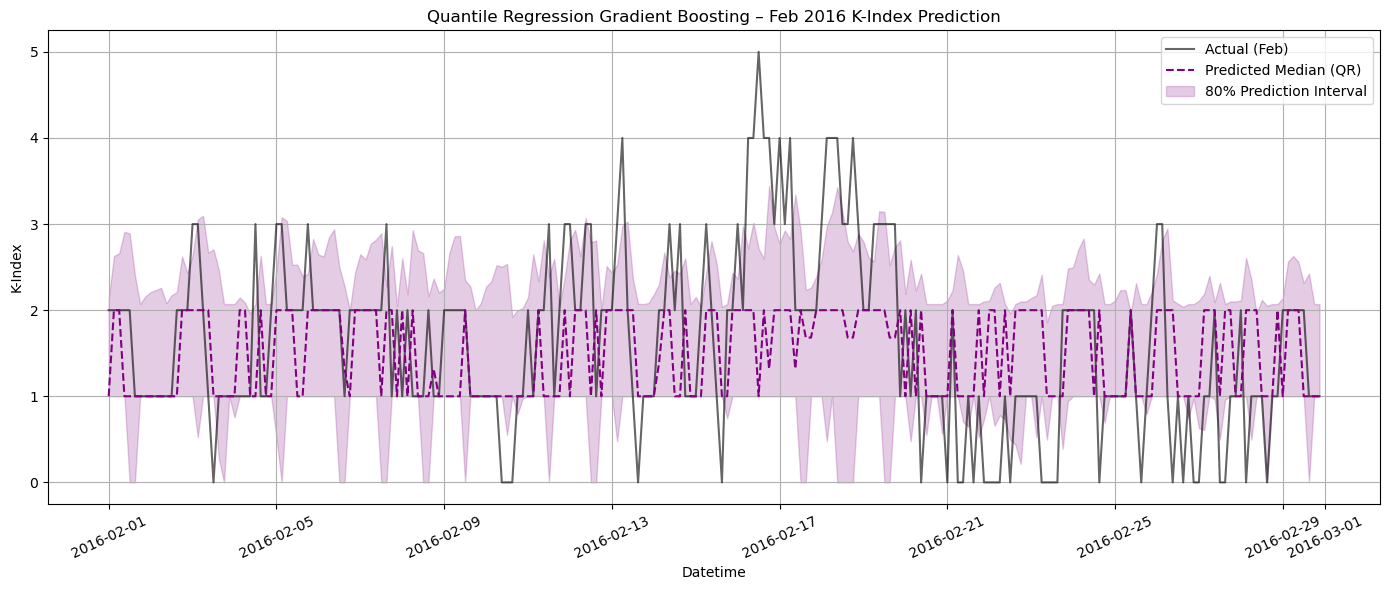

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Prepare data
merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])

# Create lag features
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)

merged_df = merged_df.dropna().reset_index(drop=True)

# Select feature columns and target
feature_cols = [f'k_lag{i}' for i in range(1, 9)] + \
               [f'eyrx_lag{i}' for i in range(1, 9)] + \
               [f'eyry_lag{i}' for i in range(1, 9)]
target_col = "k_value"

# Split into train (Jan) and test (Feb)
train_df = merged_df[(merged_df["datetime"] >= "2016-01-01") & (merged_df["datetime"] < "2016-02-01")]
test_df = merged_df[(merged_df["datetime"] >= "2016-02-01") & (merged_df["datetime"] < "2016-03-01")]

assert not train_df.empty and not test_df.empty, "Train or test dataframe is empty."

# Step 2: Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(train_df[feature_cols])
y_train = scaler_y.fit_transform(train_df[[target_col]]).flatten()
X_test = scaler_X.transform(test_df[feature_cols])
y_test = scaler_y.transform(test_df[[target_col]]).flatten()

# Step 3: Train Quantile Models
lower_alpha = 0.1
upper_alpha = 0.9

qr_median = GradientBoostingRegressor(loss='quantile', alpha=0.5, n_estimators=200, max_depth=4, random_state=0)
qr_lower  = GradientBoostingRegressor(loss='quantile', alpha=lower_alpha, n_estimators=200, max_depth=4, random_state=0)
qr_upper  = GradientBoostingRegressor(loss='quantile', alpha=upper_alpha, n_estimators=200, max_depth=4, random_state=0)

qr_median.fit(X_train, y_train)
qr_lower.fit(X_train, y_train)
qr_upper.fit(X_train, y_train)

#Step 4: Predict and Inverse Transform
y_pred_med = scaler_y.inverse_transform(qr_median.predict(X_test).reshape(-1, 1)).flatten()
y_pred_low = scaler_y.inverse_transform(qr_lower.predict(X_test).reshape(-1, 1)).flatten()
y_pred_up  = scaler_y.inverse_transform(qr_upper.predict(X_test).reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_pred_med = np.clip(y_pred_med, 0, None)
y_pred_low = np.clip(y_pred_low, 0, None)
y_pred_up  = np.clip(y_pred_up, 0, None)

# Step 5: Evaluation
RMSE_MF_K_QR = mean_squared_error(y_test_inv, y_pred_med, squared=False)
MAE_MF_K_QR = mean_absolute_error(y_test_inv, y_pred_med)
R2_MF_K_QR = r2_score(y_test_inv, y_pred_med)

print(" Quantile Regression (GBR) Evaluation:")
print(f"RMSE_MF_K_QR  : {RMSE_MF_K_QR:.4f}")
print(f"MAE_MF_K_QR   : {MAE_MF_K_QR:.4f}")
print(f"R²_MF_K_QR    : {R2_MF_K_QR:.4f}")

# Step 6: Store Results 
results_mf_k_qr = test_df[["datetime"]].copy()
results_mf_k_qr["actual_k"] = y_test_inv
results_mf_k_qr["predicted_k_qr"] = y_pred_med
results_mf_k_qr["lower_q"] = y_pred_low
results_mf_k_qr["upper_q"] = y_pred_up

# Step 7: Plot
plt.figure(figsize=(14, 6))
plt.plot(results_mf_k_qr["datetime"], results_mf_k_qr["actual_k"], label="Actual (Feb)", color='black', alpha=0.6)
plt.plot(results_mf_k_qr["datetime"], results_mf_k_qr["predicted_k_qr"], label="Predicted Median (QR)", linestyle='--', color='purple')
plt.fill_between(
    results_mf_k_qr["datetime"],
    results_mf_k_qr["lower_q"],
    results_mf_k_qr["upper_q"],
    color='purple',
    alpha=0.2,
    label=f"{int((upper_alpha - lower_alpha) * 100)}% Prediction Interval"
)
plt.title("Quantile Regression Gradient Boosting – Feb 2016 K-Index Prediction")
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.xticks(rotation=25)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Comparison Plot MC LSTM Vs Quantile Regression

/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_43020/2599121807.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


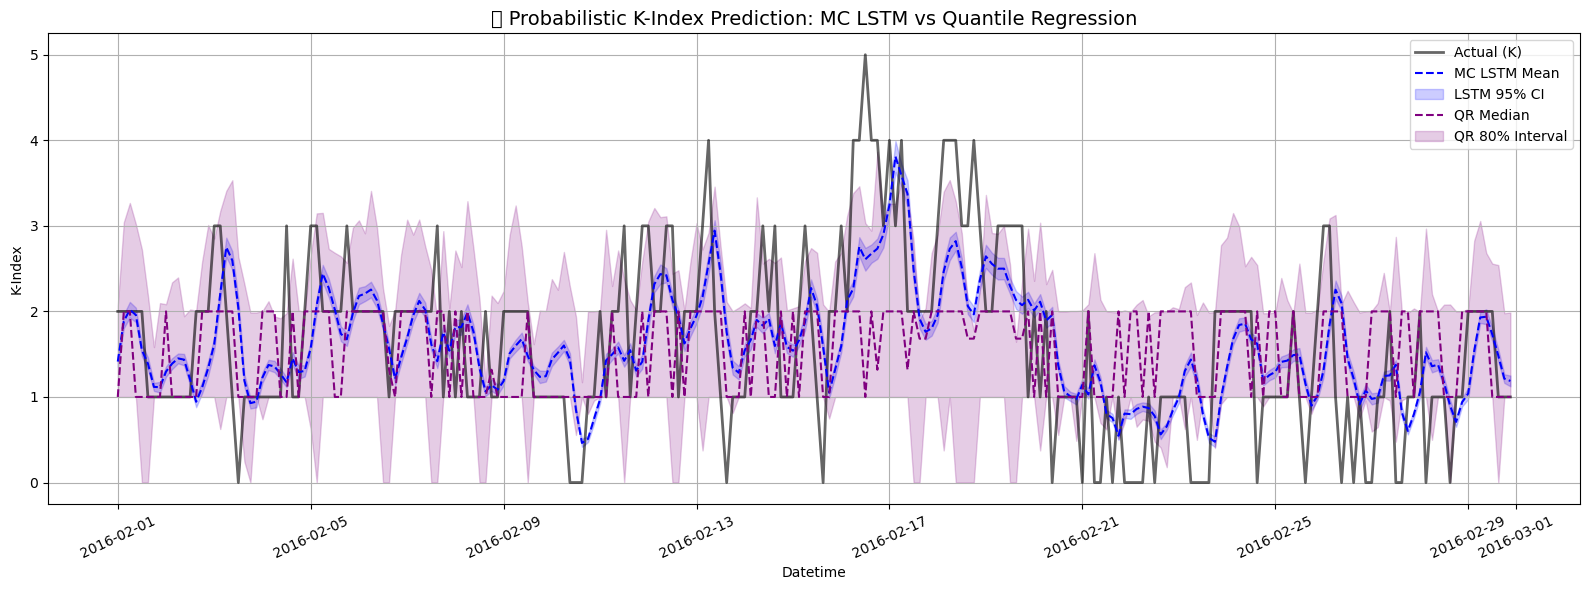

In [68]:
import matplotlib.pyplot as plt

dates_mc = pd.to_datetime(results_mf_k_mc['datetime'])
dates_qr = pd.to_datetime(results_mf_k_qr['datetime'])

common_dates = sorted(set(dates_mc).intersection(set(dates_qr)))

df_mc_plot = results_mf_k_mc[results_mf_k_mc["datetime"].isin(common_dates)].copy()
df_qr_plot = results_mf_k_qr[results_mf_k_qr["datetime"].isin(common_dates)].copy()

# Plot
plt.figure(figsize=(16, 6))

# Actual K-values
plt.plot(df_mc_plot["datetime"], df_mc_plot["actual_k"], label="Actual (K)", color="black", linewidth=2, alpha=0.6)

# MC LSTM Predictions
plt.plot(df_mc_plot["datetime"], df_mc_plot["predicted_k_mc"], label="MC LSTM Mean", linestyle='--', color="blue")
plt.fill_between(
    df_mc_plot["datetime"],
    df_mc_plot["predicted_k_mc"] - 1.96 * df_mc_plot["uncertainty_std"],
    df_mc_plot["predicted_k_mc"] + 1.96 * df_mc_plot["uncertainty_std"],
    color="blue",
    alpha=0.2,
    label="LSTM 95% CI"
)

# Quantile Regression Predictions
plt.plot(df_qr_plot["datetime"], df_qr_plot["predicted_k_qr"], label="QR Median", linestyle='--', color="purple")
plt.fill_between(
    df_qr_plot["datetime"],
    df_qr_plot["lower_q"],
    df_qr_plot["upper_q"],
    color="purple",
    alpha=0.2,
    label="QR 80% Interval"
)


plt.title("📊 Probabilistic K-Index Prediction: MC LSTM vs Quantile Regression", fontsize=14)
plt.xlabel("Datetime")
plt.ylabel("K-Index")
plt.xticks(rotation=25)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Probalistic Model Performance of Quantile Regression & Monte Carlo Dropout LSTM

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


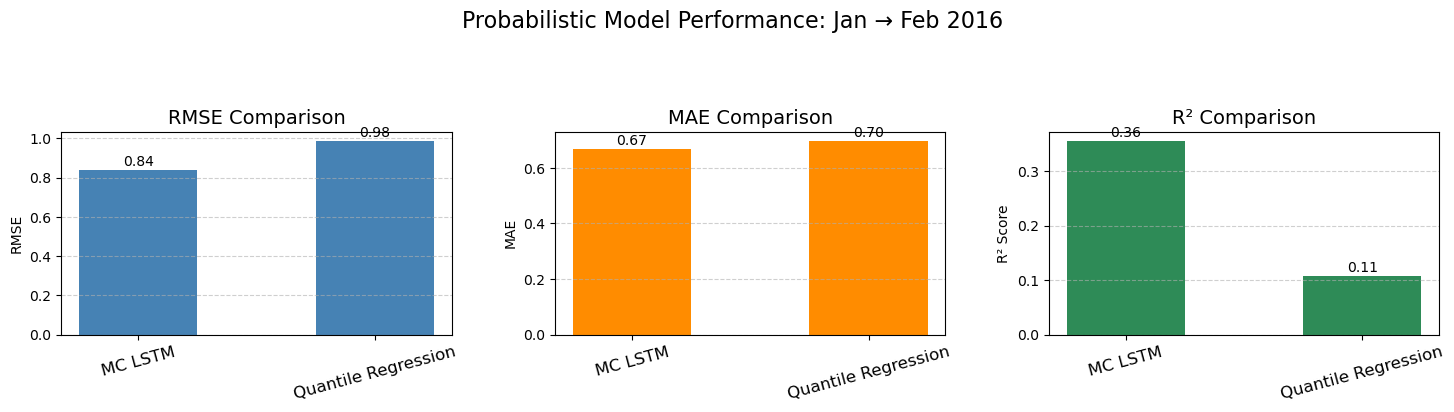

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Extract Actual & Predicted Values
actual_mc = results_mf_k_mc["actual_k"].values
predicted_mc = results_mf_k_mc["predicted_k_mc"].values

actual_qr = results_mf_k_qr["actual_k"].values
predicted_qr = results_mf_k_qr["predicted_k_qr"].values

# Step 2: Compute Metrics
rmse_vals = [
    mean_squared_error(actual_mc, predicted_mc, squared=False),
    mean_squared_error(actual_qr, predicted_qr, squared=False)
]
mae_vals = [
    mean_absolute_error(actual_mc, predicted_mc),
    mean_absolute_error(actual_qr, predicted_qr)
]
r2_vals = [
    r2_score(actual_mc, predicted_mc),
    r2_score(actual_qr, predicted_qr)
]

# Step 3: Plot
models = ['MC LSTM', 'Quantile Regression']
x = range(len(models))
bar_width = 0.5
label_fontsize = 12
title_fontsize = 14

fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

# RMSE
bars_rmse = ax[0].bar(x, rmse_vals, width=bar_width, color='steelblue')
ax[0].set_title('RMSE Comparison', fontsize=title_fontsize)
ax[0].set_xticks(x)
ax[0].set_xticklabels(models, rotation=15, fontsize=label_fontsize)
ax[0].set_ylabel('RMSE')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars_rmse:
    height = bar.get_height()
    ax[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# MAE
bars_mae = ax[1].bar(x, mae_vals, width=bar_width, color='darkorange')
ax[1].set_title('MAE Comparison', fontsize=title_fontsize)
ax[1].set_xticks(x)
ax[1].set_xticklabels(models, rotation=15, fontsize=label_fontsize)
ax[1].set_ylabel('MAE')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars_mae:
    height = bar.get_height()
    ax[1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# R²
bars_r2 = ax[2].bar(x, r2_vals, width=bar_width, color='seagreen')
ax[2].set_title('R² Comparison', fontsize=title_fontsize)
ax[2].set_xticks(x)
ax[2].set_xticklabels(models, rotation=15, fontsize=label_fontsize)
ax[2].set_ylabel('R² Score')
ax[2].grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars_r2:
    height = bar.get_height()
    ax[2].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Final Layout
plt.suptitle("Probabilistic Model Performance: Jan → Feb 2016", fontsize=16, y=1.05)
plt.tight_layout(pad=2.0)
plt.show()


Binary Classification using Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       231
           1       0.00      0.00      0.00         1

    accuracy                           0.98       232
   macro avg       0.50      0.49      0.50       232
weighted avg       0.99      0.98      0.99       232

 Confusion Matrix:
[[228   3]
 [  1   0]]
 ROC-AUC Score: 0.8268


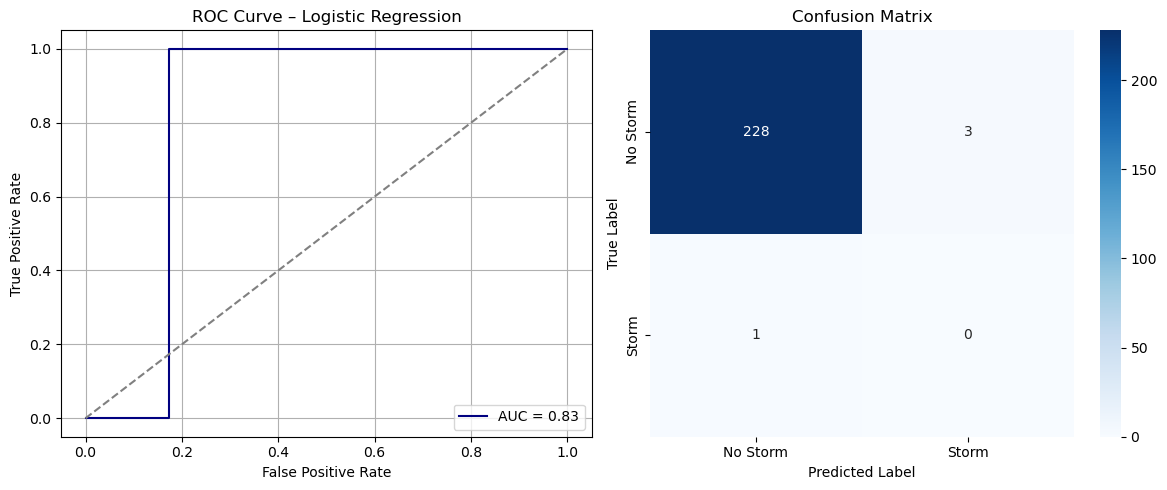

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

merged_df["datetime"] = pd.to_datetime(merged_df["datetime"], errors='coerce')
merged_df = merged_df.dropna(subset=["datetime"]).reset_index(drop=True)

# Step 1: Create binary target (1 if storm, else 0)
merged_df["is_storm"] = (merged_df["k_value"] >= 5).astype(int)

# Step 2: Create lag features
for lag in range(1, 9):
    merged_df[f"k_lag{lag}"] = merged_df["k_value"].shift(lag)
    merged_df[f"eyrx_lag{lag}"] = merged_df["eyrx"].shift(lag)
    merged_df[f"eyry_lag{lag}"] = merged_df["eyry"].shift(lag)

merged_df = merged_df.dropna().reset_index(drop=True)

# Step 3: Train/Test split
train_df = merged_df[(merged_df["datetime"] >= "2016-01-01") & (merged_df["datetime"] < "2016-02-01")]
test_df  = merged_df[(merged_df["datetime"] >= "2016-02-01") & (merged_df["datetime"] < "2016-03-01")]

# Step 4: Setup features/target
features = [f"k_lag{i}" for i in range(1, 9)] + \
           [f"eyrx_lag{i}" for i in range(1, 9)] + \
           [f"eyry_lag{i}" for i in range(1, 9)]
target = "is_storm"

X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]

# Step 5: Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Step 6: Train Logistic Regression
model_lr = LogisticRegression(max_iter=500, class_weight='balanced')
model_lr.fit(X_train_scaled, y_train)

# Step 7: Predictions
y_pred = model_lr.predict(X_test_scaled)
y_prob = model_lr.predict_proba(X_test_scaled)[:, 1]  # for ROC

# Step 8: Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print(" Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

roc_score = roc_auc_score(y_test, y_prob)
print(f" ROC-AUC Score: {roc_score:.4f}")

# Step 9: Plot ROC Curve + Confusion Matrix
fpr, tpr, _ = roc_curve(y_test, y_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
axes[0].plot(fpr, tpr, label=f"AUC = {roc_score:.2f}", color='navy')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_title("ROC Curve – Logistic Regression")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True)

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_xticklabels(['No Storm', 'Storm'])
axes[1].set_yticklabels(['No Storm', 'Storm'])

plt.tight_layout()
plt.show()


Comparison plot of k value & K+MF value for models. 

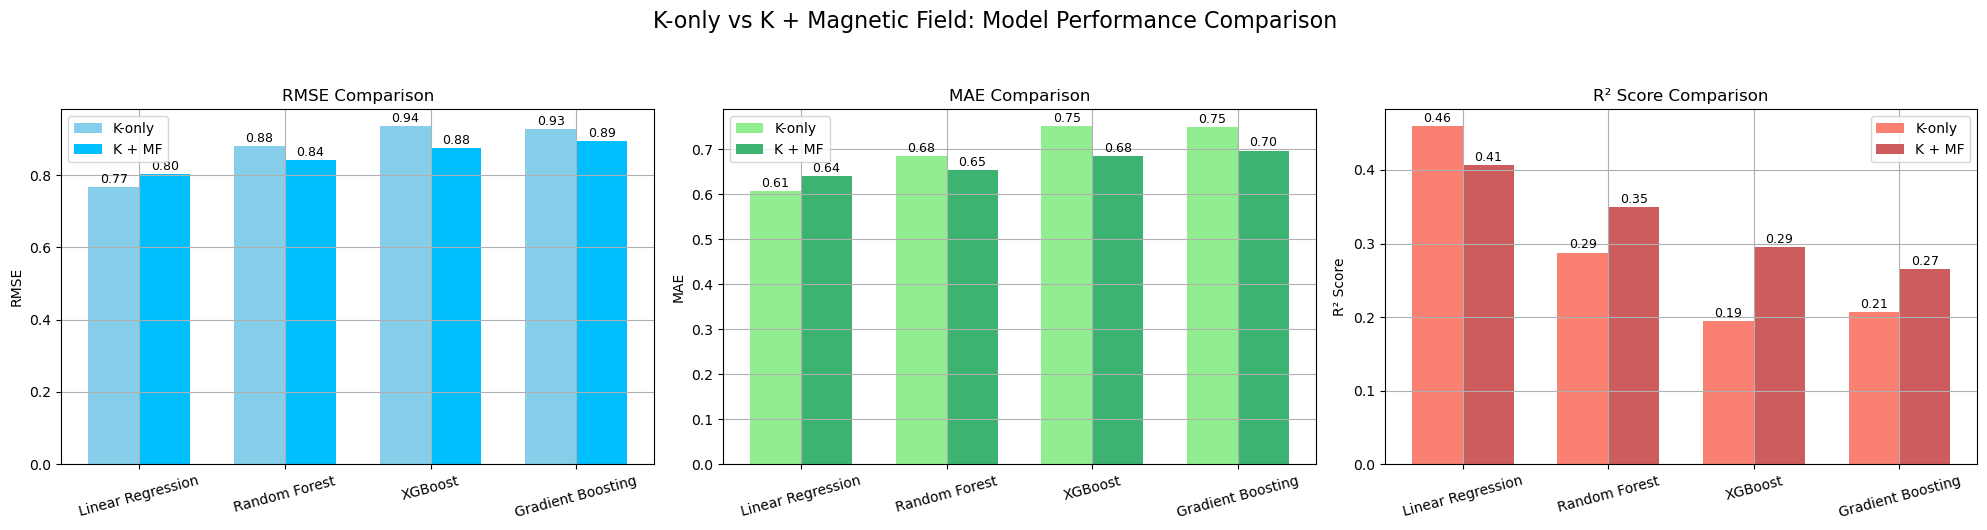

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting']
x = np.arange(len(model_names))  # [0, 1, 2, 3]
width = 0.35  # Bar width

# K-only models
rmse_k = [RMSE_LR, RMSE_RF, RMSE_XGB, RMSE_GB]
mae_k = [MAE_LR, MAE_RF, MAE_XGB, MAE_GB]
r2_k = [R2_LR, R2_RF, R2_XGB, R2_GB]

# K + Magnetic Field models
rmse_mf = [RMSE_MF_K_LR, RMSE_MF_K_RF, RMSE_MF_K_XGB, RMSE_MF_K_GB]
mae_mf = [MAE_MF_K_LR, MAE_MF_K_RF, MAE_MF_K_XGB, MAE_MF_K_GB]
r2_mf = [R2_MF_K_LR, R2_MF_K_RF, R2_MF_K_XGB, R2_MF_K_GB]

fig, axes = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

# RMSE Plot
bars1 = axes[0].bar(x - width/2, rmse_k, width, label='K-only', color='skyblue')
bars2 = axes[0].bar(x + width/2, rmse_mf, width, label='K + MF', color='deepskyblue')
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15)
axes[0].legend()
axes[0].grid(True)
for bar in bars1 + bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# MAE Plot
bars3 = axes[1].bar(x - width/2, mae_k, width, label='K-only', color='lightgreen')
bars4 = axes[1].bar(x + width/2, mae_mf, width, label='K + MF', color='mediumseagreen')
axes[1].set_title("MAE Comparison")
axes[1].set_ylabel("MAE")
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=15)
axes[1].legend()
axes[1].grid(True)
for bar in bars3 + bars4:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# R² Score Plot
bars5 = axes[2].bar(x - width/2, r2_k, width, label='K-only', color='salmon')
bars6 = axes[2].bar(x + width/2, r2_mf, width, label='K + MF', color='indianred')
axes[2].set_title("R² Score Comparison")
axes[2].set_ylabel("R² Score")
axes[2].set_xticks(x)
axes[2].set_xticklabels(model_names, rotation=15)
axes[2].legend()
axes[2].grid(True)
for bar in bars5 + bars6:
    height = bar.get_height()
    axes[2].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# Final formatting
plt.suptitle("K-only vs K + Magnetic Field: Model Performance Comparison", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


Tunned Models Comparison for Random Forest, XGboost & Gradient Boosting using K-value & K+ Magnetic Field Data

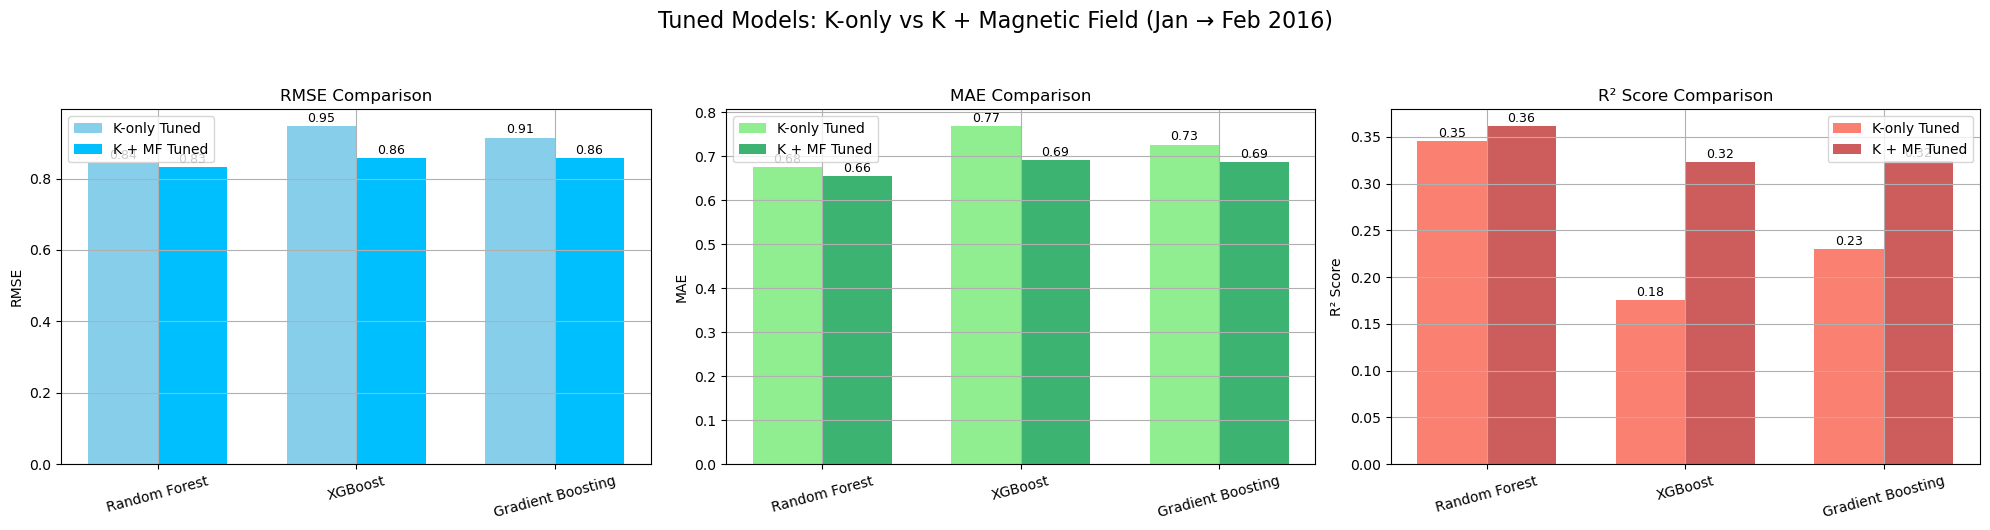

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Models
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting']
x = np.arange(len(model_names))  # [0, 1, 2]
width = 0.35

# Tuned Metric Values

# K-only
rmse_k_tuned = [RMSE_RF_tuned, RMSE_XGB_tuned, RMSE_GB_tuned]
mae_k_tuned = [MAE_RF_tuned, MAE_XGB_tuned, MAE_GB_tuned]
r2_k_tuned  = [R2_RF_tuned, R2_XGB_tuned, R2_GB_tuned]

# K + Magnetic Field
rmse_mf_tuned = [RMSE_MF_K_RF_TUNED, RMSE_MF_K_XGB_TUNED, RMSE_MF_K_GB_TUNED]
mae_mf_tuned = [MAE_MF_K_RF_TUNED, MAE_MF_K_XGB_TUNED, MAE_MF_K_GB_TUNED]
r2_mf_tuned  = [R2_MF_K_RF_TUNED, R2_MF_K_XGB_TUNED, R2_MF_K_GB_TUNED]

# Create Subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

# RMSE
bars1 = axes[0].bar(x - width/2, rmse_k_tuned, width, label='K-only Tuned', color='skyblue')
bars2 = axes[0].bar(x + width/2, rmse_mf_tuned, width, label='K + MF Tuned', color='deepskyblue')
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15)
axes[0].legend()
axes[0].grid(True)

for bar in bars1 + bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# MAE 
bars3 = axes[1].bar(x - width/2, mae_k_tuned, width, label='K-only Tuned', color='lightgreen')
bars4 = axes[1].bar(x + width/2, mae_mf_tuned, width, label='K + MF Tuned', color='mediumseagreen')
axes[1].set_title("MAE Comparison")
axes[1].set_ylabel("MAE")
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=15)
axes[1].legend()
axes[1].grid(True)

for bar in bars3 + bars4:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# R² Score
bars5 = axes[2].bar(x - width/2, r2_k_tuned, width, label='K-only Tuned', color='salmon')
bars6 = axes[2].bar(x + width/2, r2_mf_tuned, width, label='K + MF Tuned', color='indianred')
axes[2].set_title("R² Score Comparison")
axes[2].set_ylabel("R² Score")
axes[2].set_xticks(x)
axes[2].set_xticklabels(model_names, rotation=15)
axes[2].legend()
axes[2].grid(True)

for bar in bars5 + bars6:
    height = bar.get_height()
    axes[2].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)


plt.suptitle("Tuned Models: K-only vs K + Magnetic Field (Jan → Feb 2016)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


Comparison of Probalistic Models K-only Vs K + Magnetic Field. 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


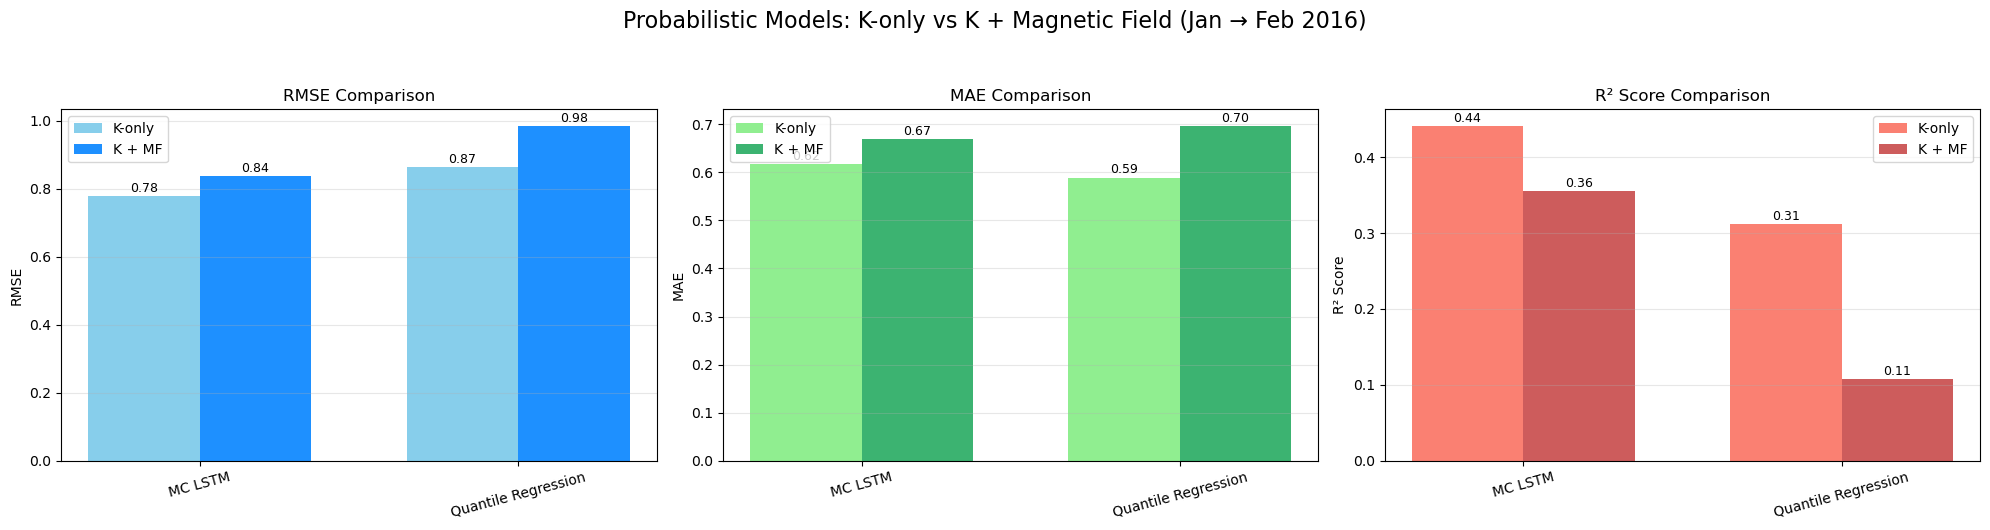

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Evaluate from Stored Data
# K-only models
rmse_k_only = [RMSE_LSTM_MC, rmse_qr]
mae_k_only = [MAE_LSTM_MC, mae_qr]
r2_k_only = [R2_LSTM_MC, r2_qr]

# K + Magnetic Field models
rmse_k_mf = [
    mean_squared_error(results_mf_k_mc["actual_k"], results_mf_k_mc["predicted_k_mc"], squared=False),
    mean_squared_error(results_mf_k_qr["actual_k"], results_mf_k_qr["predicted_k_qr"], squared=False)
]
mae_k_mf = [
    mean_absolute_error(results_mf_k_mc["actual_k"], results_mf_k_mc["predicted_k_mc"]),
    mean_absolute_error(results_mf_k_qr["actual_k"], results_mf_k_qr["predicted_k_qr"])
]
r2_k_mf = [
    r2_score(results_mf_k_mc["actual_k"], results_mf_k_mc["predicted_k_mc"]),
    r2_score(results_mf_k_qr["actual_k"], results_mf_k_qr["predicted_k_qr"])
]

# Step 2: Plot Setup
models = ["MC LSTM", "Quantile Regression"]
x = np.arange(len(models))
width = 0.35

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

# RMSE Plot
bars_rmse_k = axes[0].bar(x - width/2, rmse_k_only, width, label='K-only', color='skyblue')
bars_rmse_mf = axes[0].bar(x + width/2, rmse_k_mf, width, label='K + MF', color='dodgerblue')
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15)
axes[0].legend()
axes[0].grid(True, axis='y', alpha=0.3)

# Annotate RMSE
for bar in bars_rmse_k + bars_rmse_mf:
    height = bar.get_height()
    axes[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# MAE Plot
bars_mae_k = axes[1].bar(x - width/2, mae_k_only, width, label='K-only', color='lightgreen')
bars_mae_mf = axes[1].bar(x + width/2, mae_k_mf, width, label='K + MF', color='mediumseagreen')
axes[1].set_title("MAE Comparison")
axes[1].set_ylabel("MAE")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15)
axes[1].legend()
axes[1].grid(True, axis='y', alpha=0.3)

# Annotate MAE
for bar in bars_mae_k + bars_mae_mf:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# R² Plot
bars_r2_k = axes[2].bar(x - width/2, r2_k_only, width, label='K-only', color='salmon')
bars_r2_mf = axes[2].bar(x + width/2, r2_k_mf, width, label='K + MF', color='indianred')
axes[2].set_title("R² Score Comparison")
axes[2].set_ylabel("R² Score")
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=15)
axes[2].legend()
axes[2].grid(True, axis='y', alpha=0.3)

# Annotate R²
for bar in bars_r2_k + bars_r2_mf:
    height = bar.get_height()
    axes[2].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# Final Formatting
plt.suptitle("Probabilistic Models: K-only vs K + Magnetic Field (Jan → Feb 2016)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()
